In [4]:
!pip3 install torch torchvision

    100% |████████████████████████████████| 519.5MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59874000 @  0x7f220f9502a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 21.5MB/s 
    100% |████████████████████████████████| 2.0MB 5.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


## 1. Import required libraries

In [0]:
# Vanilla GAN with Multi GPUs + Naming Layers using OrderedDict
# Code by GunhoChoi

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

## 2. Hyperparameter setting

In [0]:
# Set Hyperparameters
# change num_gpu to the number of gpus you want to use

epoch = 50
batch_size = 512
learning_rate = 0.0002
num_gpus = 1

## 3. Data Setting

In [7]:
# Download Data

mnist_train = dset.MNIST("./data/", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ]),
                        target_transform=None,
                        download=True)

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)

Processing...
Done!


## 4. Generator

In [0]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module): #Generator는 이미지를 생성한다. #Autoencoder의 decoder가 GAN의 Generator에 해당. 
    #Autoencoder의 decoder에는 원래 latent vector가 있어야 하지만 GAN에서는 random noise에서 생성하는 것이 기본이다.
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*256), #Linear 함수로 길이를 늘려준다.
             nn.BatchNorm1d(7*7*256),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(OrderedDict([
            ('conv1', nn.ConvTranspose2d(256,128,3,2,1,1)),
            ('bn1', nn.BatchNorm2d(128)), #일괄 정규화. 성능과 안정성을 향상시킨다. 
            #Gradient Vanishing / Gradient Exploding를 방지한다.
            #배치 정규화는 레이어의 입력 데이터 분포가 치우쳐져 있을 때 평균과 분산을 조정해주는 역할을 한다. 
            #이는 역전파가 각 레이어에 쉽게 전달되도록 해 학습이 안정적으로 이뤄지도록 돕는 데 중요한 역할을 한다.
            ('relu1', nn.LeakyReLU()), #relu와 비슷하지만, -가 되도 0이 아닌 약간의 값을 가진다.
            ('conv2', nn.ConvTranspose2d(128,64,3,1,1)),
            ('bn2', nn.BatchNorm2d(64)),    
            ('relu2', nn.LeakyReLU()),
        ]))
        self.layer3 = nn.Sequential(OrderedDict([
            ('conv3',nn.ConvTranspose2d(64,16,3,1,1)),
            ('bn3',nn.BatchNorm2d(16)),    
            ('relu3',nn.LeakyReLU()),
            ('conv4',nn.ConvTranspose2d(16,1,3,2,1,1)),
            ('relu4',nn.Tanh())
        ]))

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(batch_size//num_gpus,256,7,7) #size 변환
        out = self.layer2(out)
        out = self.layer3(out)
        return out

## 5. Discriminator

In [0]:
# Discriminator receives 1x28x28 image and returns a float number 0~1
# we can name each layer using OrderedDict

class Discriminator(nn.Module): #Discriminator는 생성된 이미지를 판별한다.
    #Generator가 fake data를 생성하고, real data와 번갈아 가면서 Discriminator에 넣어준다.
    #Discriminator는 fake data는 0로, real data는 1로 판별해야 한다.
    #즉, Generator는 fake data를 Discriminator가 real로 판단하도록 학습되어야 한다.
    #따라서, Discriminator가 모두 올바르게 판단하면 loss는 0. 모두 잘못 판단하면, 무한대가 나온다.
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(OrderedDict([
            ('conv1',nn.Conv2d(1,8,3,padding=1)),   # batch x 16 x 28 x 28
            #('bn1',nn.BatchNorm2d(8)),    
            ('relu1',nn.LeakyReLU()), #relu와 비슷하지만, -가 되도 0이 아닌 약간의 값을 가진다.
            ('conv2',nn.Conv2d(8,16,3,padding=1)),  # batch x 32 x 28 x 28
            ('bn2',nn.BatchNorm2d(16)),    
            ('relu2',nn.LeakyReLU()),
            ('max1',nn.MaxPool2d(2,2))   # batch x 32 x 14 x 14
        ]))
        self.layer2 = nn.Sequential(OrderedDict([
            ('conv3',nn.Conv2d(16,32,3,padding=1)),  # batch x 64 x 14 x 14
            ('bn3',nn.BatchNorm2d(32)),
            ('relu3',nn.LeakyReLU()),
            ('max2',nn.MaxPool2d(2,2)),
            ('conv4',nn.Conv2d(32,64,3,padding=1)),  # batch x 128 x 7 x 7
            ('bn4',nn.BatchNorm2d(64)),
            ('relu4',nn.LeakyReLU())
        ]))
        self.fc = nn.Sequential(
            nn.Linear(64*7*7,1),
            nn.Sigmoid() #최종적으로 0 또는 1의 값을 내야 하므로 sigmoid로 0~1의 값으로 만들어 준다.
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size//num_gpus, -1)
        out = self.fc(out)
        return out

## 6. Put instances on Multi-gpu

In [0]:
# Put class objects on Multiple GPUs using 
# torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
# device_ids: default all devices / output_device: default device 0 
# along with .cuda()

generator = nn.DataParallel(Generator()).cuda()
discriminator = nn.DataParallel(Discriminator()).cuda()
#DataParallel는 Multi GPU에 모델을 올릴 수 있다.

## 7. Check layers

In [11]:
# Get parameter list by using class.state_dict().keys()

gen_params = generator.state_dict().keys()
dis_params = discriminator.state_dict().keys()

for i in gen_params:
    print(i)

module.layer1.0.weight
module.layer1.0.bias
module.layer1.1.weight
module.layer1.1.bias
module.layer1.1.running_mean
module.layer1.1.running_var
module.layer1.1.num_batches_tracked
module.layer2.conv1.weight
module.layer2.conv1.bias
module.layer2.bn1.weight
module.layer2.bn1.bias
module.layer2.bn1.running_mean
module.layer2.bn1.running_var
module.layer2.bn1.num_batches_tracked
module.layer2.conv2.weight
module.layer2.conv2.bias
module.layer2.bn2.weight
module.layer2.bn2.bias
module.layer2.bn2.running_mean
module.layer2.bn2.running_var
module.layer2.bn2.num_batches_tracked
module.layer3.conv3.weight
module.layer3.conv3.bias
module.layer3.bn3.weight
module.layer3.bn3.bias
module.layer3.bn3.running_mean
module.layer3.bn3.running_var
module.layer3.bn3.num_batches_tracked
module.layer3.conv4.weight
module.layer3.conv4.bias


## 8. Set Loss function & Optimizer

In [0]:
# loss function, optimizers, and labels for training

loss_func = nn.MSELoss()
#label이 0 또는 1이기 때문에 보통은 Binary Cross Entropy loss를 사용한다. 
gen_optim = torch.optim.Adam(generator.parameters(), lr= 5*learning_rate,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate,betas=(0.5,0.999))
#model.parameters() 로 업데이트해야 할 모든 변수들을 한 번에 가져와 간단히 구현할 수 있다.
#손실에서 lr만큼 움직이고 업데이트 하던 것을 알아서 최적화해서 처리해 준다.
#각 파라미터들을 따로 학습해야 하기 때문에 모델의 optim을 따로 정의해 준다.

ones_label = Variable(torch.ones(batch_size,1)).cuda() #정답. real은 1에 가깝게 나와야 한다.
zeros_label = Variable(torch.zeros(batch_size,1)).cuda() #정답. fake는 0에 가깝게 나와야 한다.

def image_check(gen_fake):
    img = gen_fake.data.numpy()
    for i in range(10):
        plt.imshow(img[i][0],cmap='gray')
        plt.show()

## 9. Restore Model

In [13]:
# model restore if any

try:
    generator, discriminator = torch.load('./model/dcgan.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model not restored--------



## 10. Train Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


tensor(0.2095, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.6006, device='cuda:0', grad_fn=<ThAddBackward>)
0th iteration gen_loss: 0.20951873064041138 dis_loss: 0.6006121039390564
tensor(0.5171, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2424, device='cuda:0', grad_fn=<ThAddBackward>)
0th iteration gen_loss: 0.5170524716377258 dis_loss: 0.2423807680606842
tensor(0.7427, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0454, device='cuda:0', grad_fn=<ThAddBackward>)
0th iteration gen_loss: 0.742729663848877 dis_loss: 0.045447804033756256


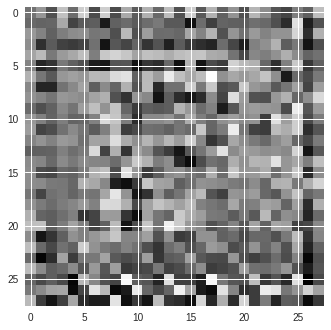

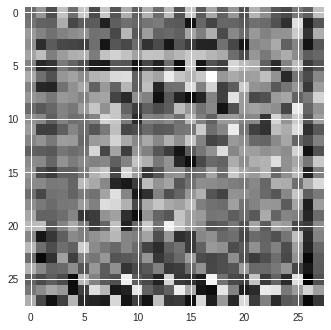

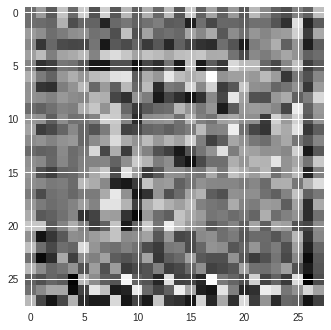

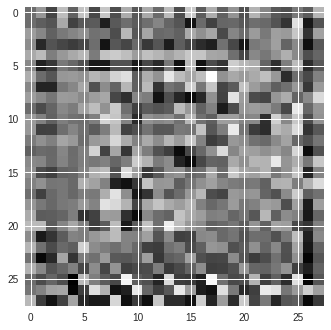

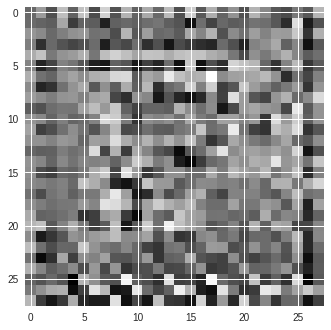

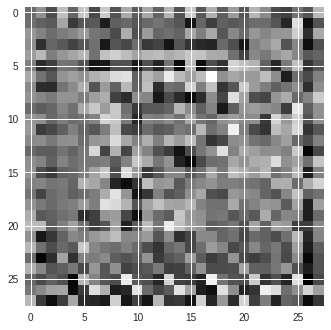

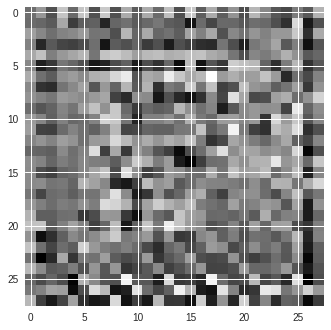

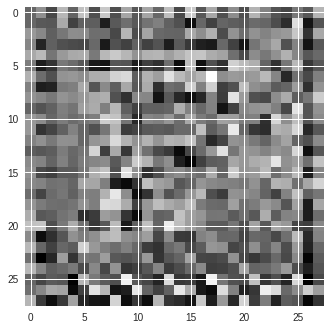

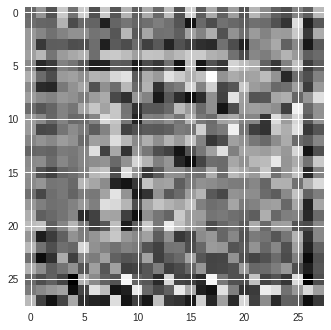

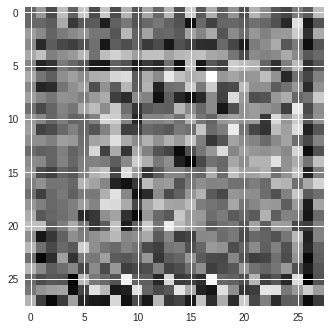

tensor(0.8017, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0239, device='cuda:0', grad_fn=<ThAddBackward>)
1th iteration gen_loss: 0.8016666769981384 dis_loss: 0.02386358380317688
tensor(0.8677, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0099, device='cuda:0', grad_fn=<ThAddBackward>)
1th iteration gen_loss: 0.8676561117172241 dis_loss: 0.00988626666367054
tensor(0.8845, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0067, device='cuda:0', grad_fn=<ThAddBackward>)
1th iteration gen_loss: 0.8844864964485168 dis_loss: 0.006717437878251076


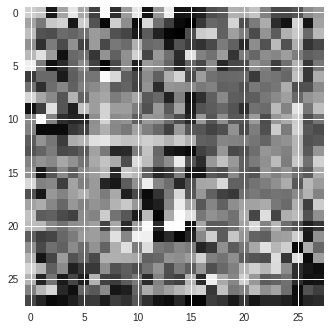

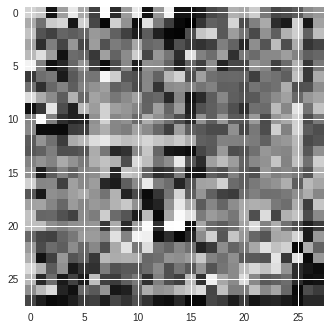

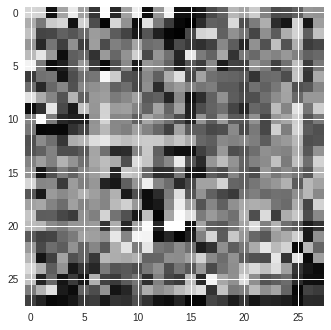

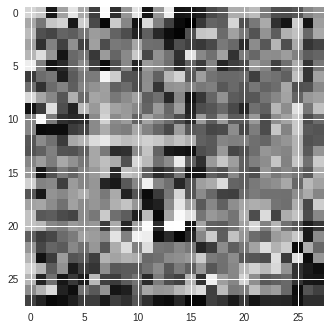

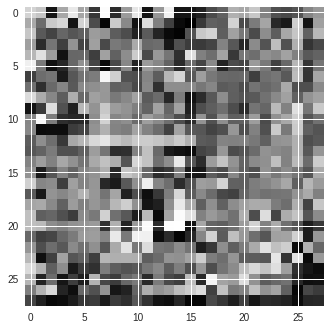

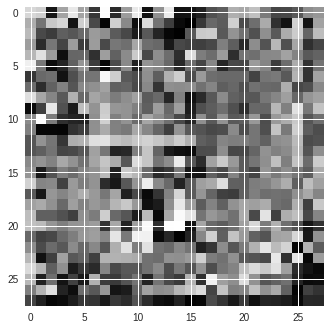

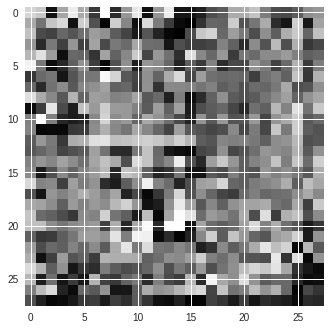

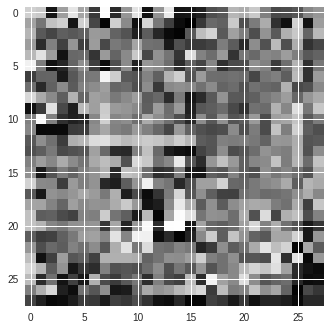

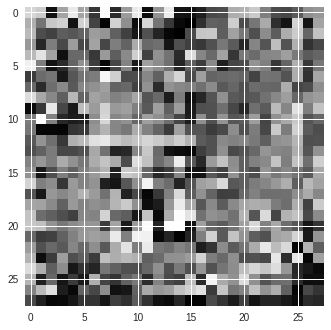

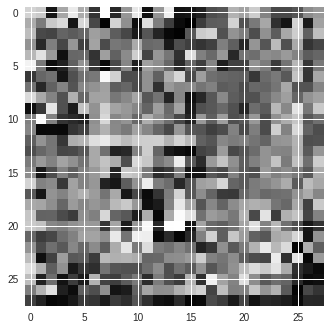

tensor(0.8916, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0055, device='cuda:0', grad_fn=<ThAddBackward>)
2th iteration gen_loss: 0.8916341066360474 dis_loss: 0.005483473651111126
tensor(0.9035, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0063, device='cuda:0', grad_fn=<ThAddBackward>)
2th iteration gen_loss: 0.9035290479660034 dis_loss: 0.006296277046203613
tensor(0.9255, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0029, device='cuda:0', grad_fn=<ThAddBackward>)
2th iteration gen_loss: 0.9255451560020447 dis_loss: 0.002905910834670067


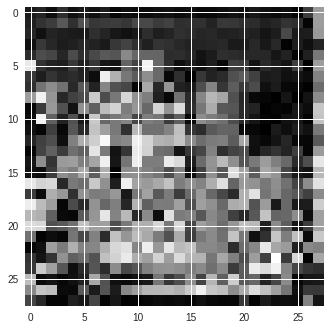

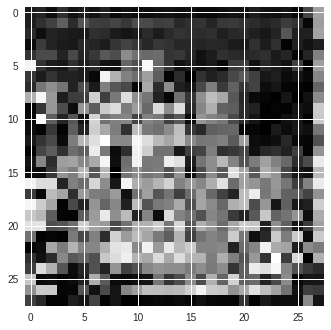

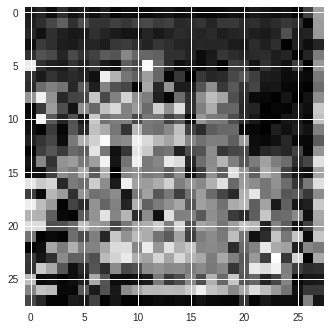

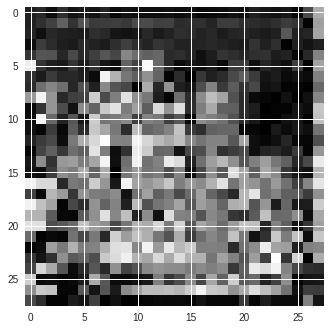

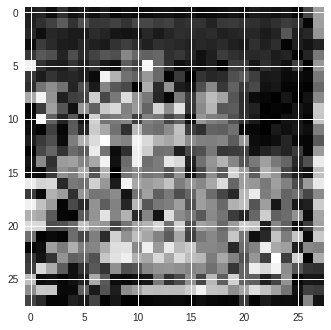

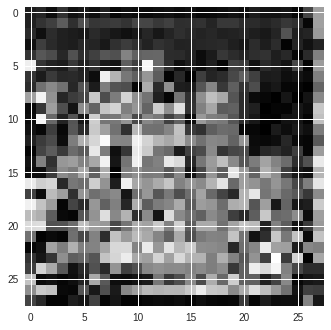

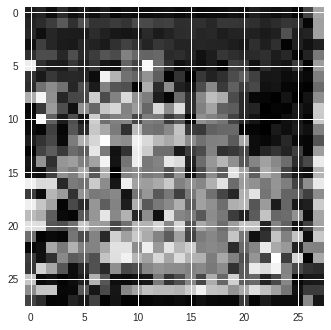

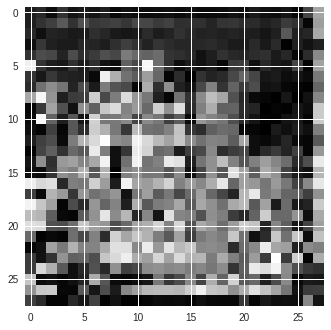

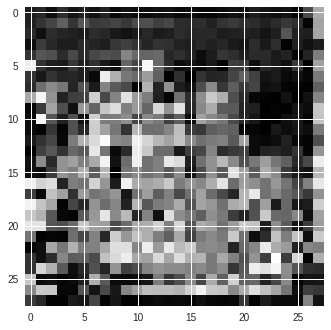

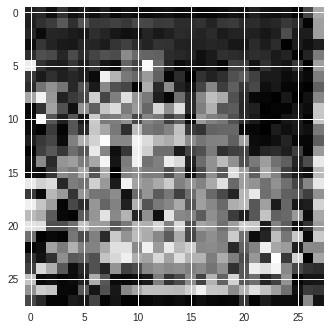

tensor(0.9152, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0035, device='cuda:0', grad_fn=<ThAddBackward>)
3th iteration gen_loss: 0.9152029156684875 dis_loss: 0.0034896833822131157
tensor(0.9339, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0024, device='cuda:0', grad_fn=<ThAddBackward>)
3th iteration gen_loss: 0.933867335319519 dis_loss: 0.002359855454415083
tensor(0.7221, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1892, device='cuda:0', grad_fn=<ThAddBackward>)
3th iteration gen_loss: 0.7220579981803894 dis_loss: 0.189206063747406


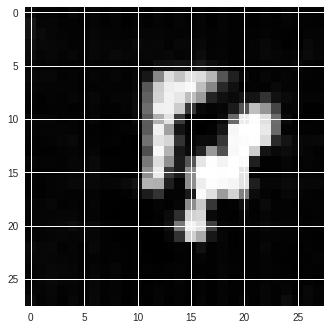

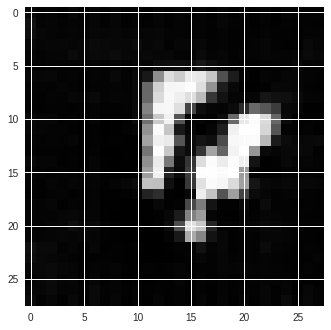

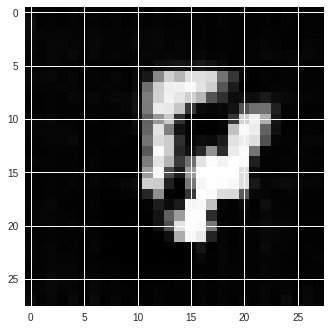

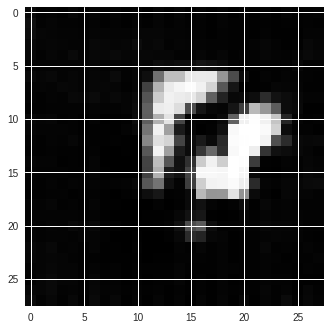

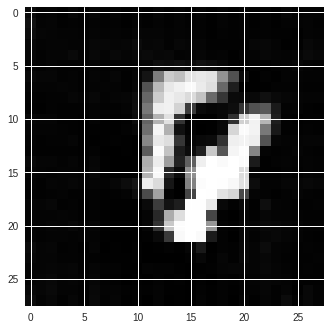

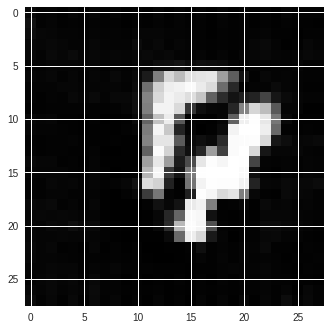

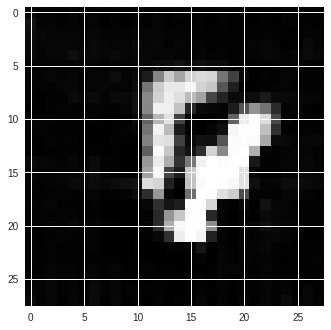

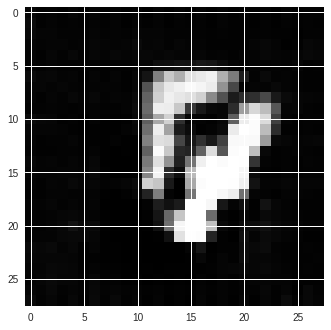

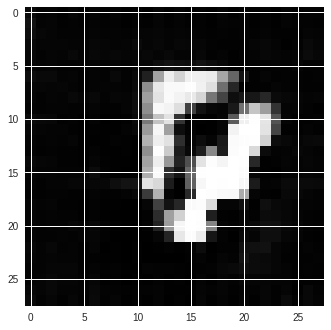

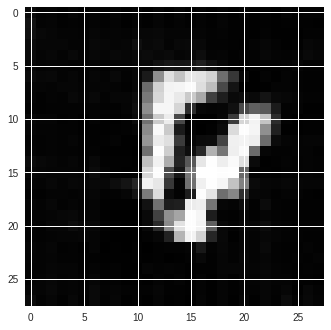

tensor(0.6197, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2239, device='cuda:0', grad_fn=<ThAddBackward>)
4th iteration gen_loss: 0.6196905374526978 dis_loss: 0.2238888144493103
tensor(0.5184, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2617, device='cuda:0', grad_fn=<ThAddBackward>)
4th iteration gen_loss: 0.5183880925178528 dis_loss: 0.2617352306842804
tensor(0.5845, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4711, device='cuda:0', grad_fn=<ThAddBackward>)
4th iteration gen_loss: 0.5844864845275879 dis_loss: 0.47109508514404297


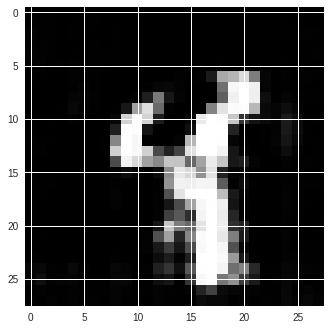

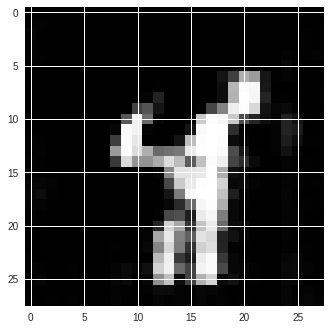

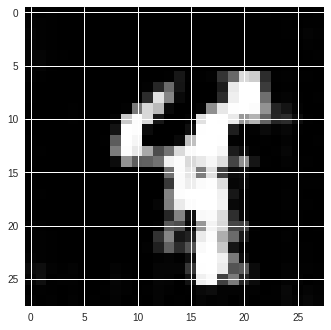

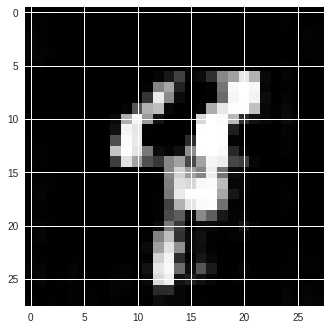

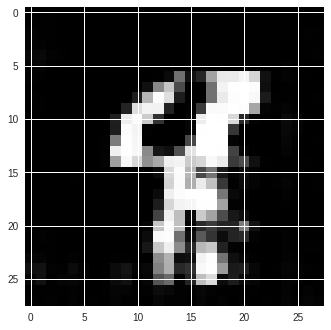

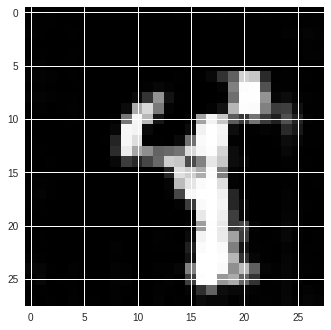

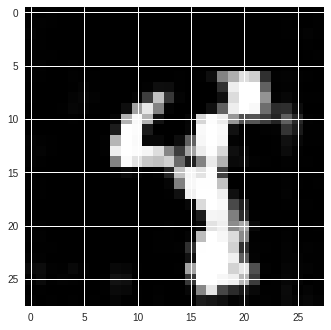

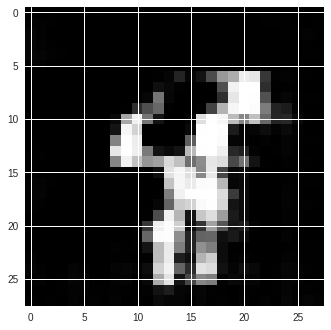

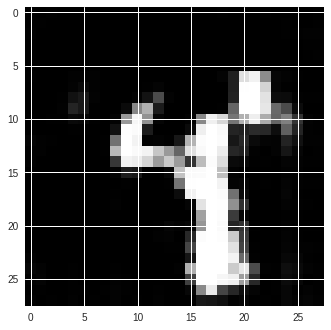

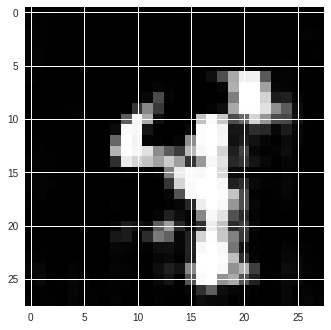

tensor(0.4708, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.6028, device='cuda:0', grad_fn=<ThAddBackward>)
5th iteration gen_loss: 0.47078269720077515 dis_loss: 0.6027965545654297
tensor(0.7151, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1592, device='cuda:0', grad_fn=<ThAddBackward>)
5th iteration gen_loss: 0.7151042222976685 dis_loss: 0.15924564003944397
tensor(0.4851, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.7546, device='cuda:0', grad_fn=<ThAddBackward>)
5th iteration gen_loss: 0.48509103059768677 dis_loss: 0.7546062469482422


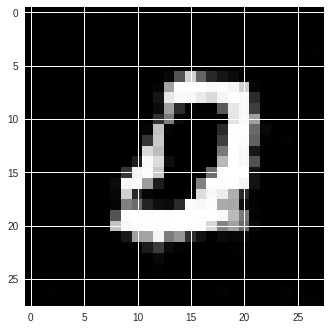

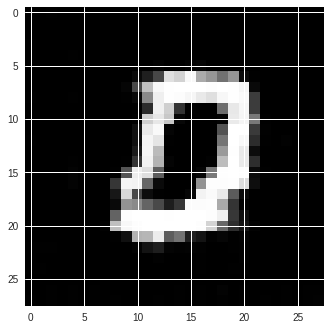

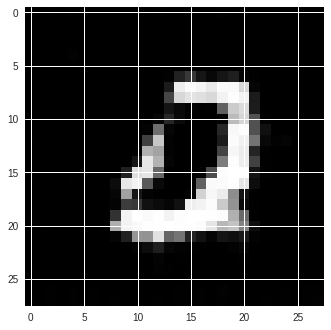

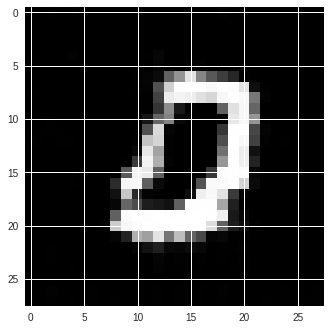

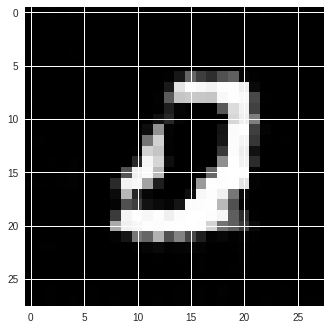

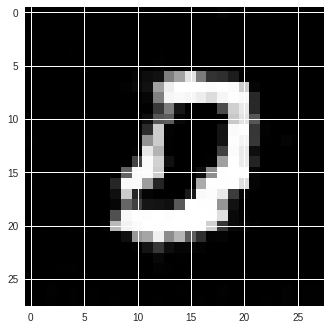

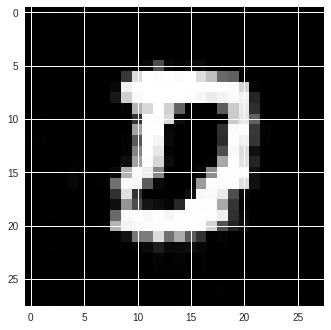

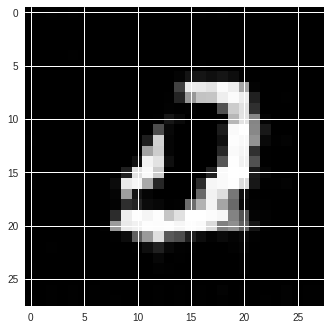

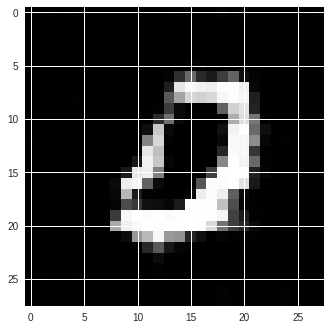

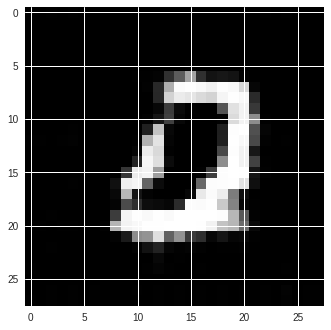

tensor(0.5574, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2802, device='cuda:0', grad_fn=<ThAddBackward>)
6th iteration gen_loss: 0.5574245452880859 dis_loss: 0.2802498936653137
tensor(0.6792, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1298, device='cuda:0', grad_fn=<ThAddBackward>)
6th iteration gen_loss: 0.6791682839393616 dis_loss: 0.12976498901844025
tensor(0.5559, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3366, device='cuda:0', grad_fn=<ThAddBackward>)
6th iteration gen_loss: 0.5558852553367615 dis_loss: 0.33660435676574707


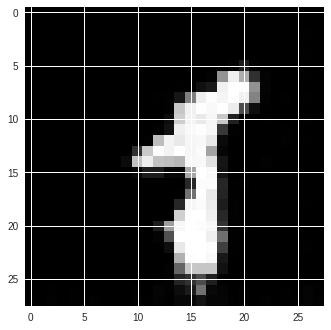

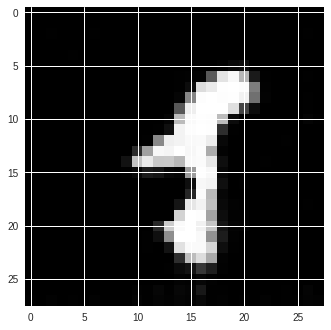

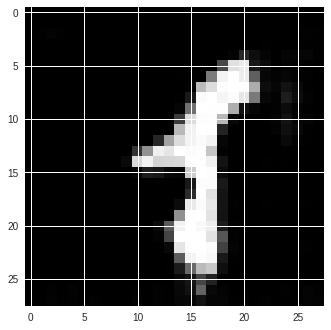

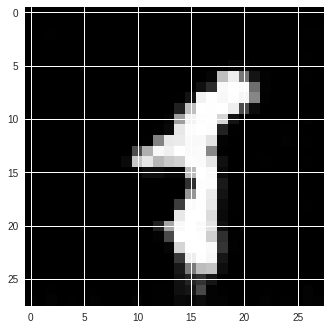

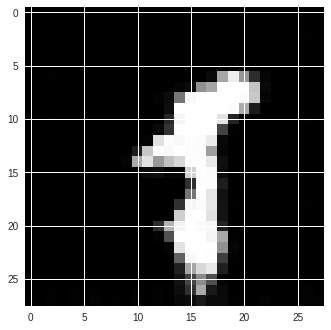

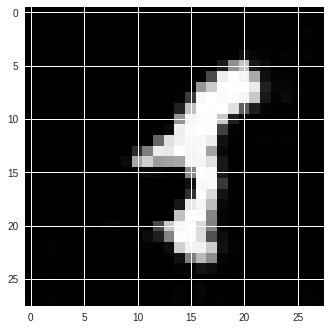

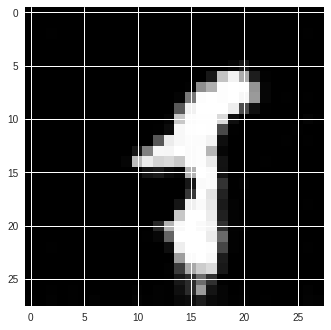

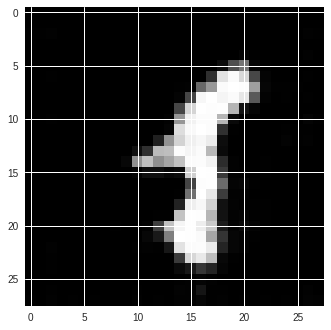

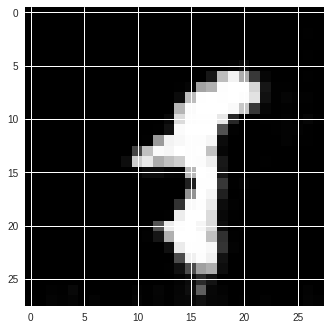

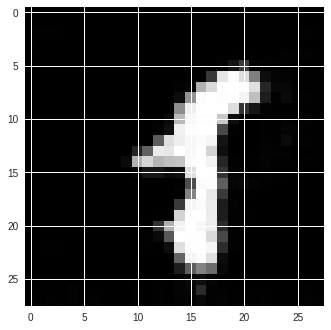

tensor(0.4956, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3205, device='cuda:0', grad_fn=<ThAddBackward>)
7th iteration gen_loss: 0.49564337730407715 dis_loss: 0.3205057978630066
tensor(0.6505, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2691, device='cuda:0', grad_fn=<ThAddBackward>)
7th iteration gen_loss: 0.6504772901535034 dis_loss: 0.26912203431129456
tensor(0.5855, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3129, device='cuda:0', grad_fn=<ThAddBackward>)
7th iteration gen_loss: 0.5855124592781067 dis_loss: 0.3129462003707886


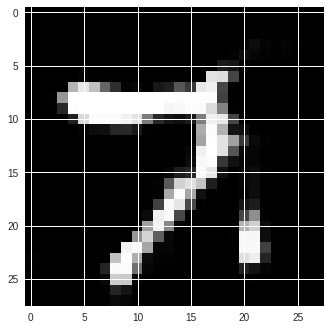

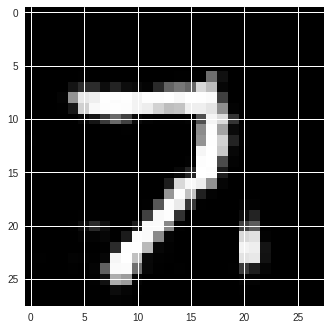

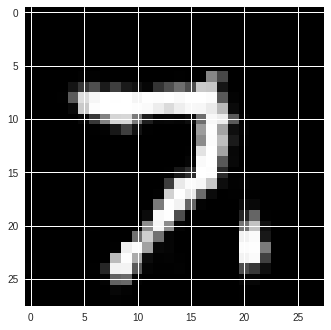

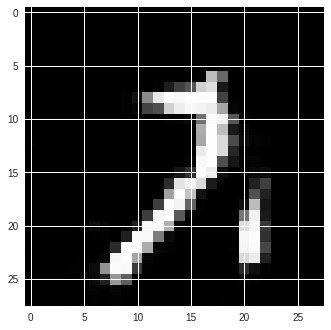

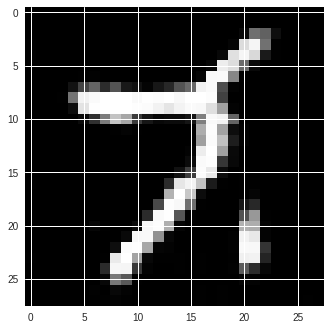

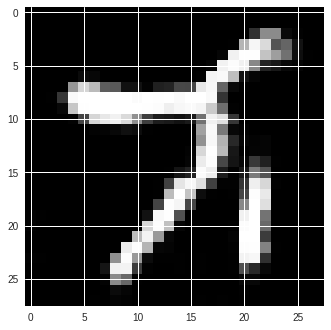

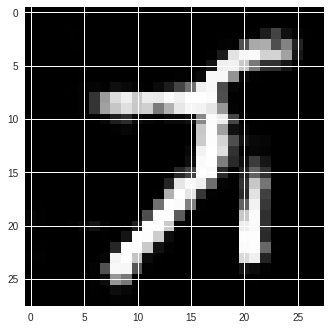

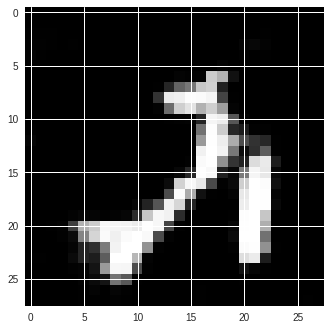

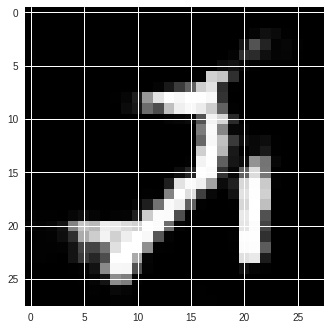

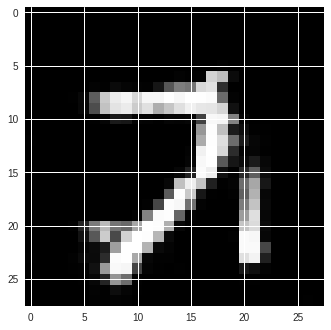

tensor(0.7366, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0904, device='cuda:0', grad_fn=<ThAddBackward>)
8th iteration gen_loss: 0.736587643623352 dis_loss: 0.09038402140140533
tensor(0.6391, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2301, device='cuda:0', grad_fn=<ThAddBackward>)
8th iteration gen_loss: 0.6390813589096069 dis_loss: 0.23005995154380798
tensor(0.7582, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1791, device='cuda:0', grad_fn=<ThAddBackward>)
8th iteration gen_loss: 0.7581573724746704 dis_loss: 0.17907023429870605


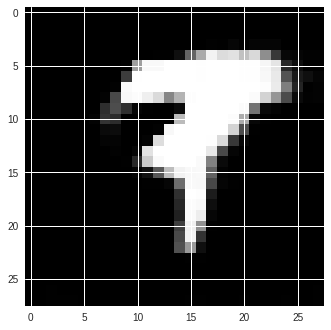

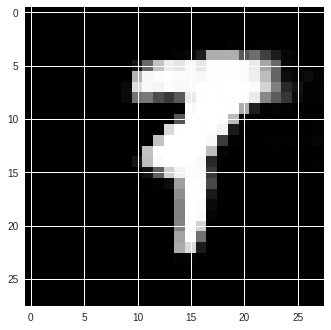

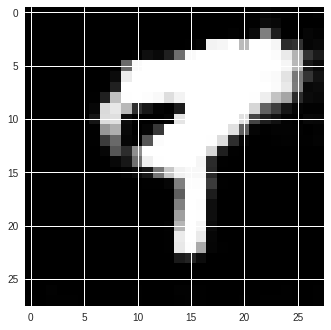

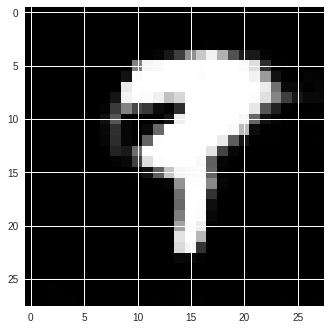

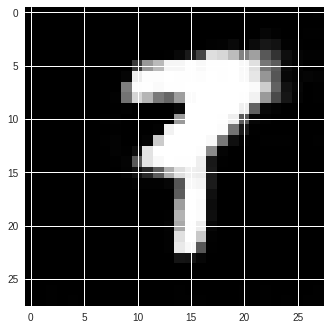

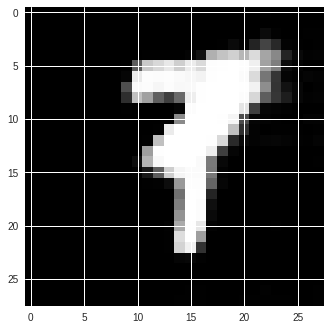

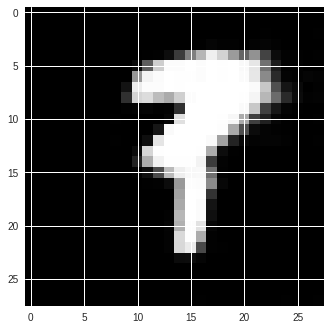

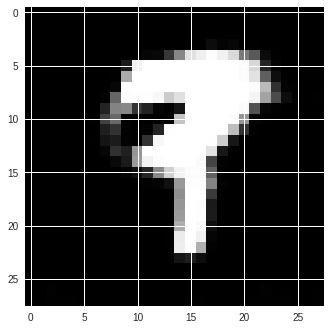

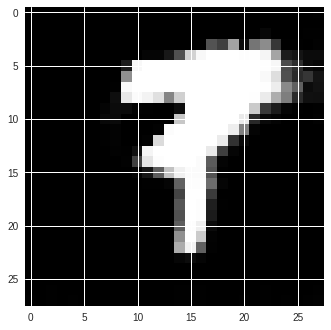

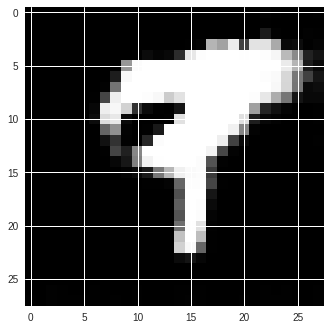

tensor(0.5321, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.5199, device='cuda:0', grad_fn=<ThAddBackward>)
9th iteration gen_loss: 0.532145619392395 dis_loss: 0.5199075937271118
tensor(0.6494, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1962, device='cuda:0', grad_fn=<ThAddBackward>)
9th iteration gen_loss: 0.6494059562683105 dis_loss: 0.19617870450019836
tensor(0.6134, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3712, device='cuda:0', grad_fn=<ThAddBackward>)
9th iteration gen_loss: 0.6134200096130371 dis_loss: 0.3712391257286072


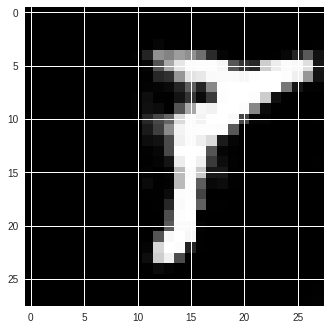

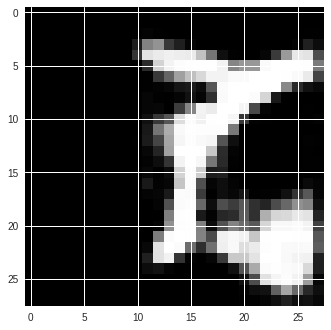

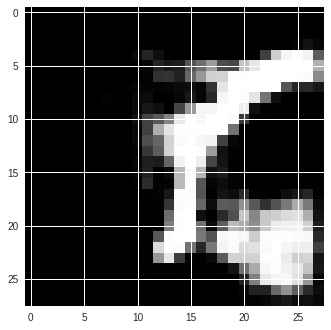

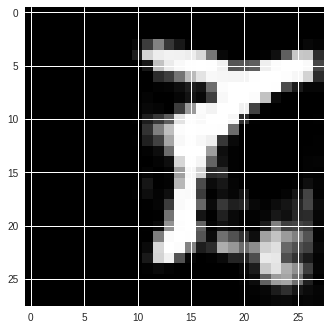

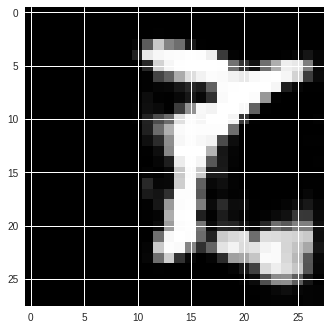

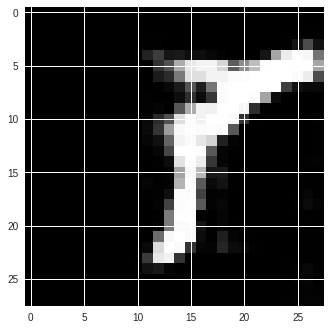

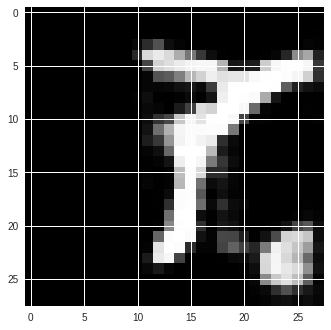

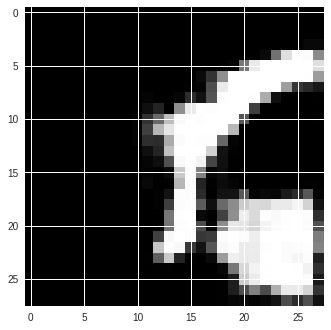

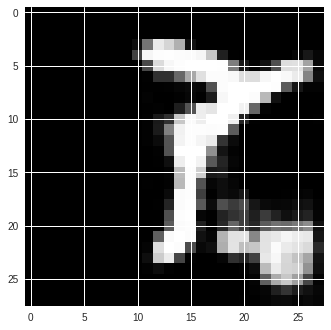

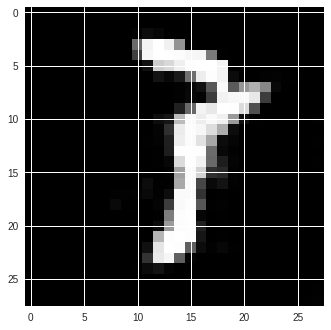

tensor(0.7038, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1633, device='cuda:0', grad_fn=<ThAddBackward>)
10th iteration gen_loss: 0.7037612795829773 dis_loss: 0.16332904994487762
tensor(0.6146, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.5019, device='cuda:0', grad_fn=<ThAddBackward>)
10th iteration gen_loss: 0.6146122217178345 dis_loss: 0.5019146203994751
tensor(0.6080, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3390, device='cuda:0', grad_fn=<ThAddBackward>)
10th iteration gen_loss: 0.6080213785171509 dis_loss: 0.33897534012794495


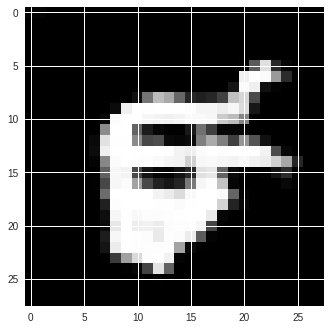

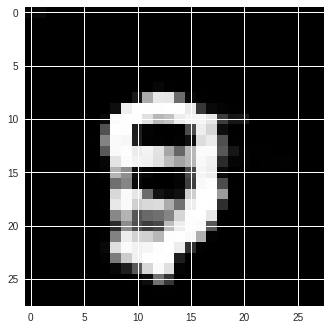

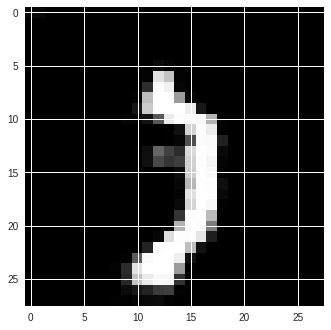

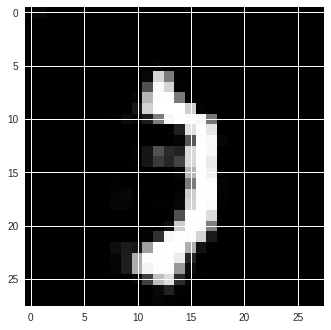

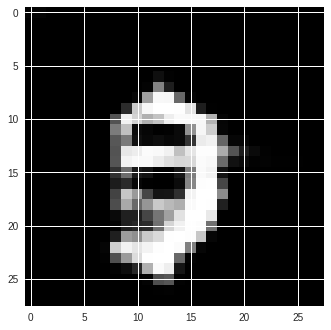

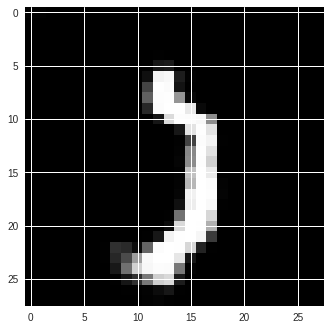

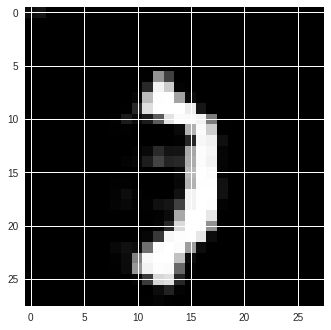

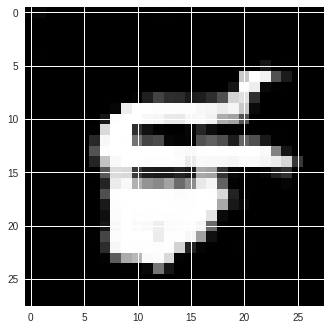

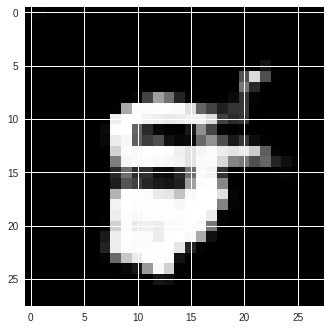

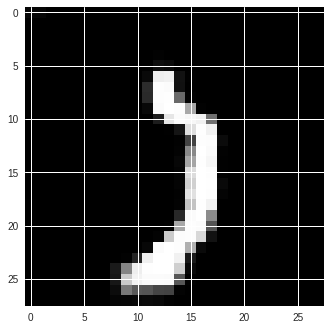

tensor(0.5541, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2229, device='cuda:0', grad_fn=<ThAddBackward>)
11th iteration gen_loss: 0.5540594458580017 dis_loss: 0.22287920117378235
tensor(0.7089, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3351, device='cuda:0', grad_fn=<ThAddBackward>)
11th iteration gen_loss: 0.7089142799377441 dis_loss: 0.3350531756877899
tensor(0.5636, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.5423, device='cuda:0', grad_fn=<ThAddBackward>)
11th iteration gen_loss: 0.5635761022567749 dis_loss: 0.542343020439148


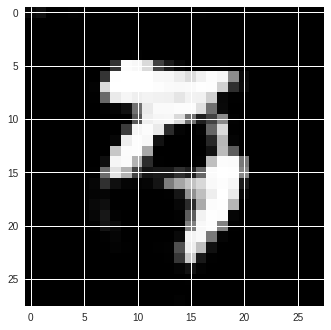

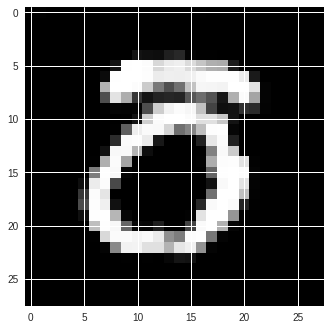

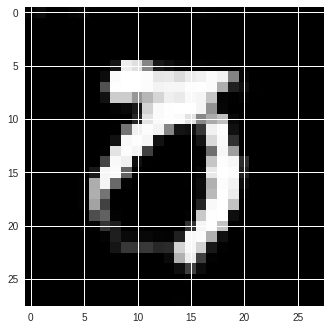

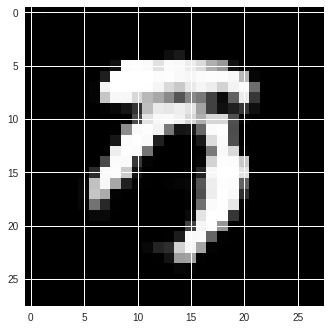

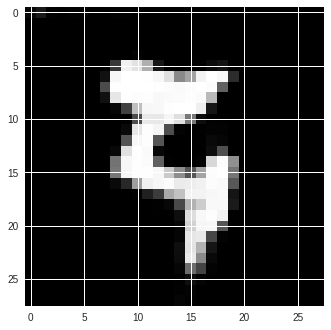

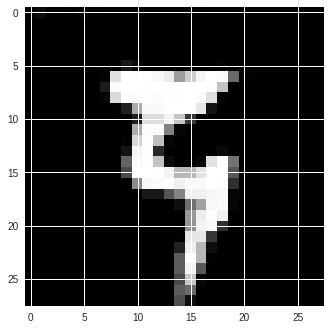

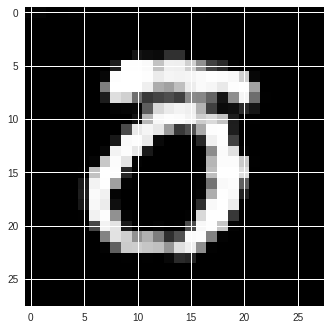

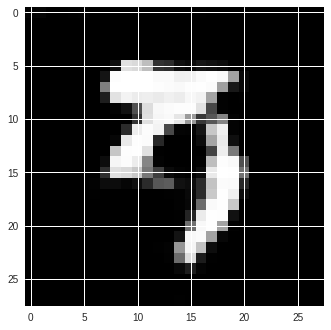

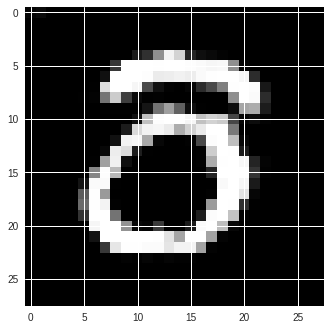

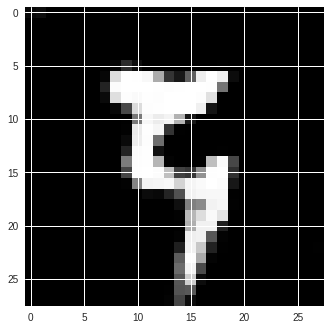

tensor(0.4803, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4073, device='cuda:0', grad_fn=<ThAddBackward>)
12th iteration gen_loss: 0.4802730679512024 dis_loss: 0.40728288888931274
tensor(0.6367, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2252, device='cuda:0', grad_fn=<ThAddBackward>)
12th iteration gen_loss: 0.6366597414016724 dis_loss: 0.22517408430576324
tensor(0.6152, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2624, device='cuda:0', grad_fn=<ThAddBackward>)
12th iteration gen_loss: 0.6152265071868896 dis_loss: 0.2623865604400635


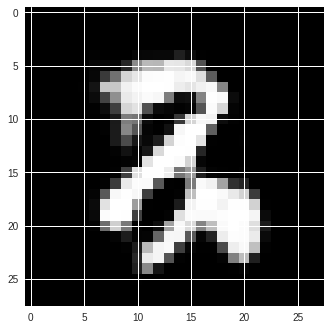

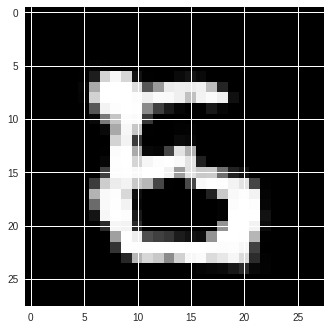

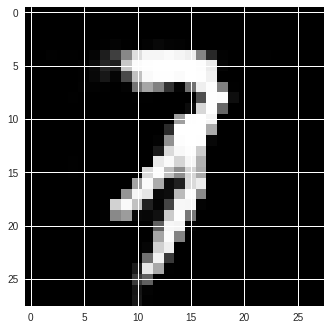

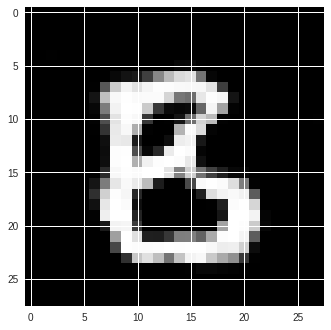

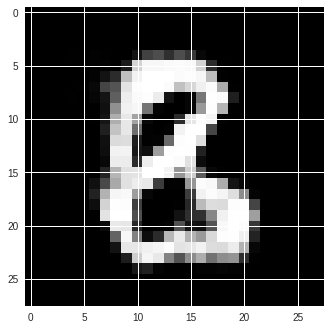

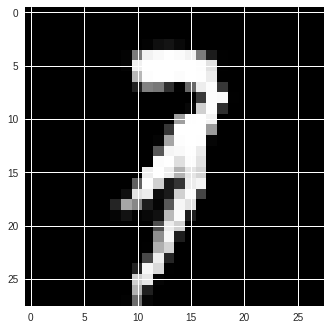

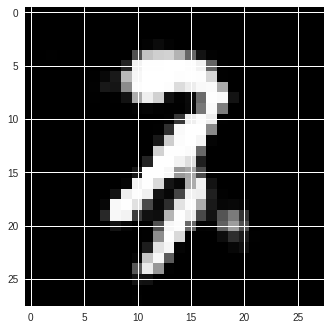

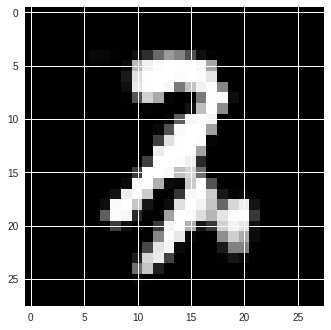

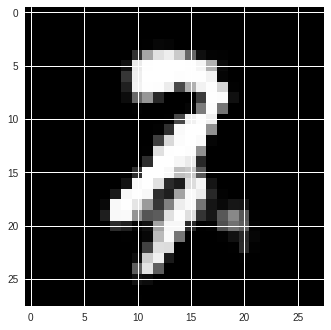

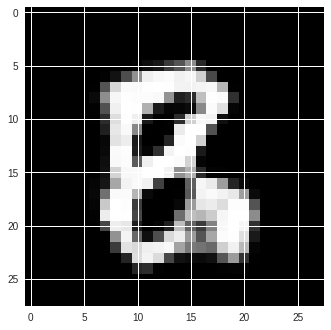

tensor(0.5664, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2242, device='cuda:0', grad_fn=<ThAddBackward>)
13th iteration gen_loss: 0.5664369463920593 dis_loss: 0.22422881424427032
tensor(0.5003, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3875, device='cuda:0', grad_fn=<ThAddBackward>)
13th iteration gen_loss: 0.5003247261047363 dis_loss: 0.38750457763671875
tensor(0.5497, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3486, device='cuda:0', grad_fn=<ThAddBackward>)
13th iteration gen_loss: 0.5497483611106873 dis_loss: 0.3486056327819824


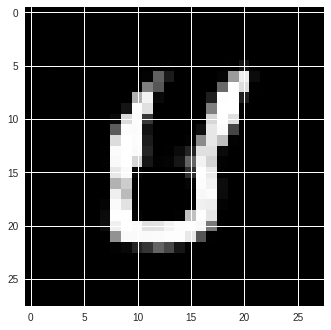

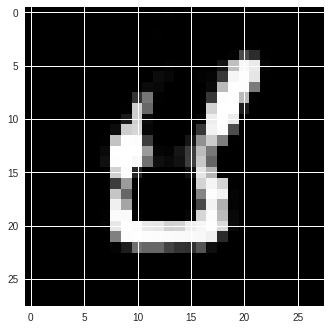

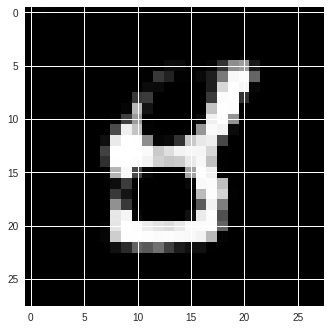

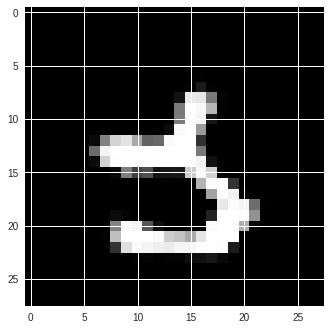

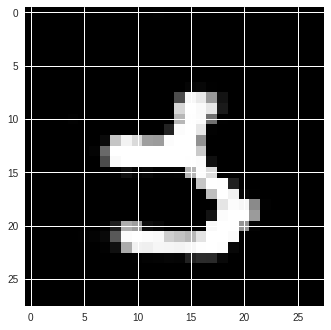

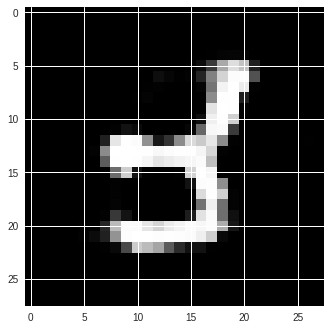

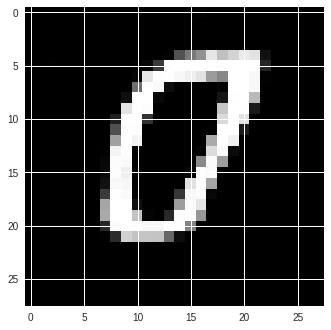

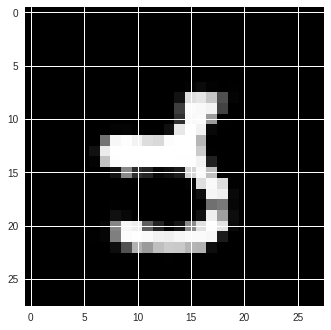

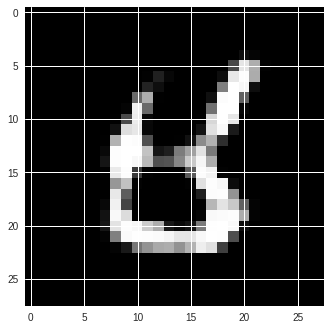

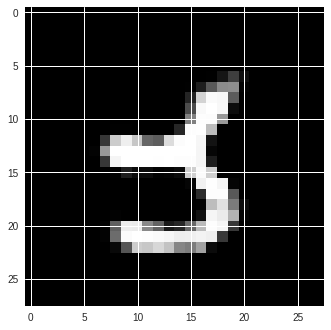

tensor(0.4593, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2911, device='cuda:0', grad_fn=<ThAddBackward>)
14th iteration gen_loss: 0.4592842161655426 dis_loss: 0.29113876819610596
tensor(0.5412, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3183, device='cuda:0', grad_fn=<ThAddBackward>)
14th iteration gen_loss: 0.5412099361419678 dis_loss: 0.3183126449584961
tensor(0.6201, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3309, device='cuda:0', grad_fn=<ThAddBackward>)
14th iteration gen_loss: 0.6200893521308899 dis_loss: 0.3309015929698944


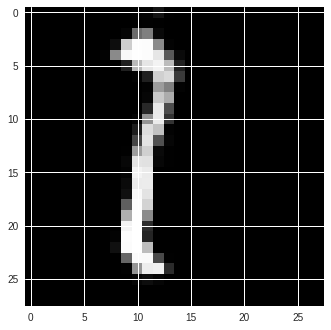

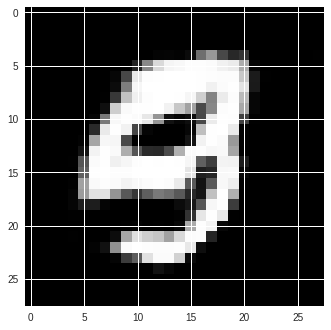

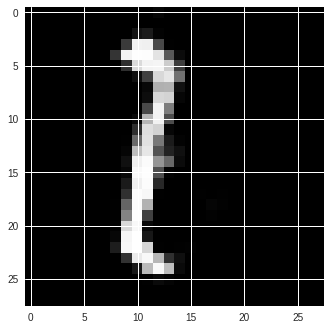

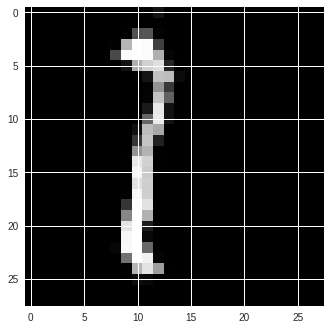

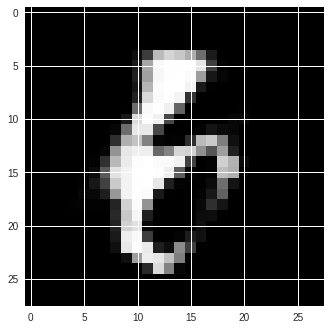

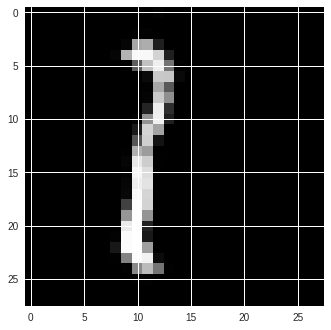

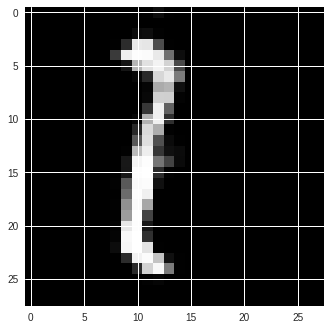

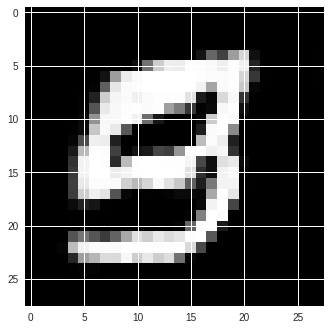

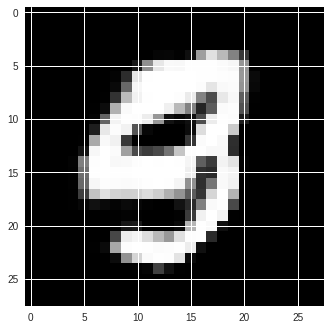

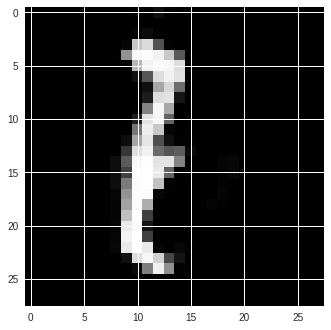

tensor(0.5547, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2159, device='cuda:0', grad_fn=<ThAddBackward>)
15th iteration gen_loss: 0.5547100901603699 dis_loss: 0.21594545245170593
tensor(0.5122, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3022, device='cuda:0', grad_fn=<ThAddBackward>)
15th iteration gen_loss: 0.5122104287147522 dis_loss: 0.30218419432640076
tensor(0.6331, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1668, device='cuda:0', grad_fn=<ThAddBackward>)
15th iteration gen_loss: 0.6330519318580627 dis_loss: 0.16678687930107117


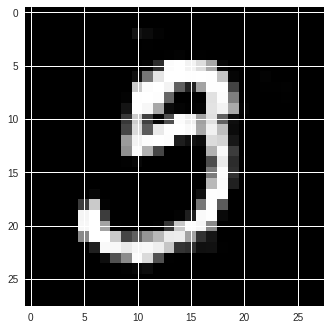

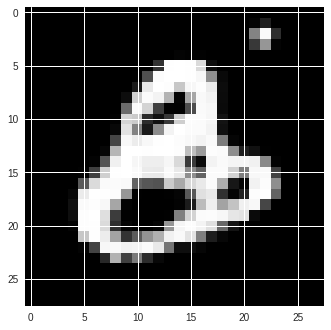

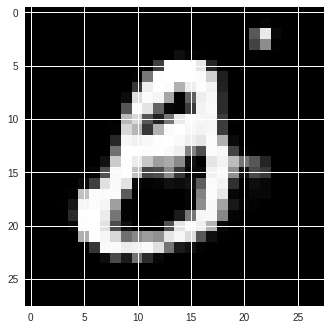

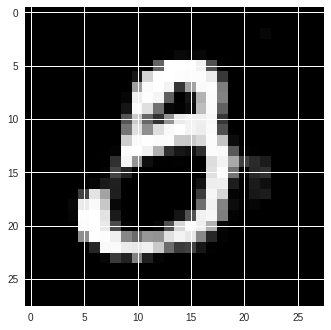

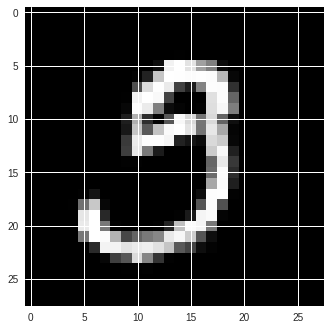

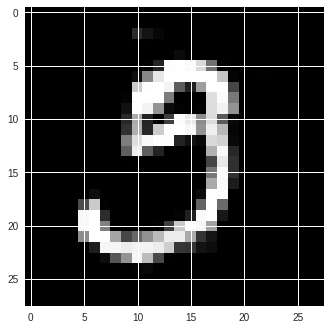

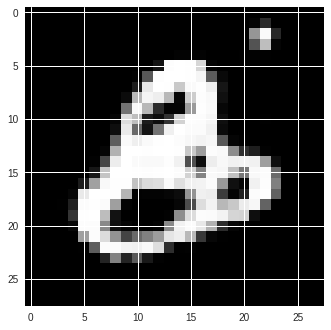

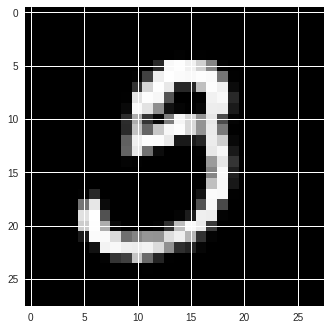

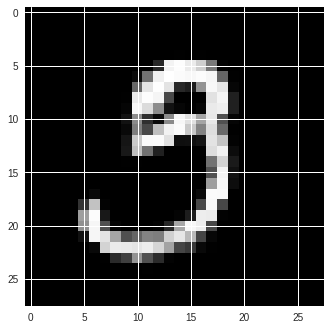

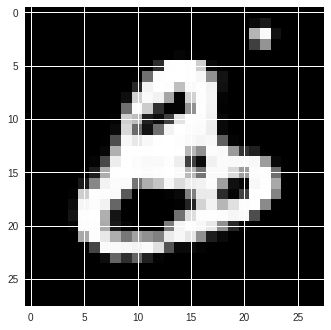

tensor(0.7354, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1598, device='cuda:0', grad_fn=<ThAddBackward>)
16th iteration gen_loss: 0.735359787940979 dis_loss: 0.15981751680374146
tensor(0.7110, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.5098, device='cuda:0', grad_fn=<ThAddBackward>)
16th iteration gen_loss: 0.7110130786895752 dis_loss: 0.5097967982292175
tensor(0.4259, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4567, device='cuda:0', grad_fn=<ThAddBackward>)
16th iteration gen_loss: 0.42593929171562195 dis_loss: 0.45665621757507324


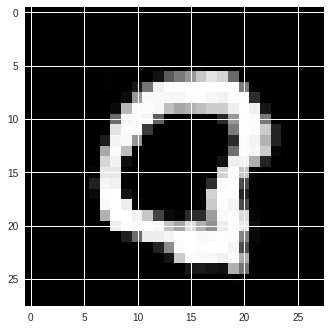

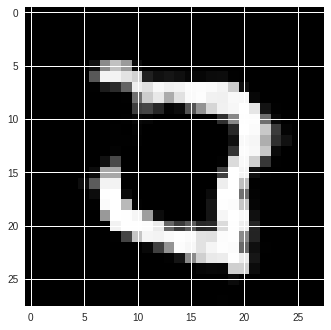

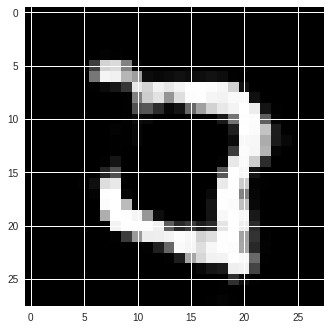

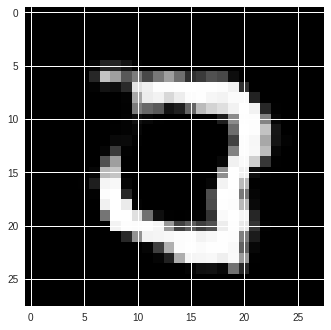

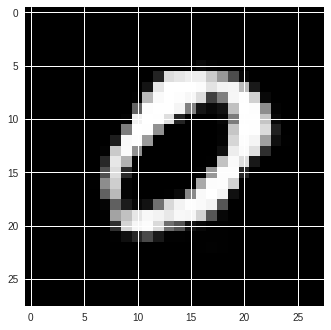

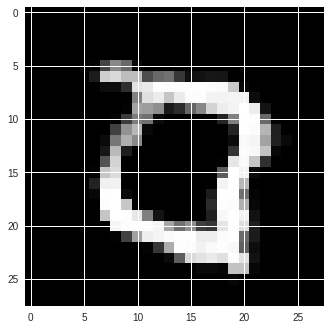

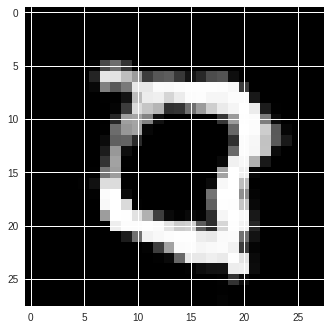

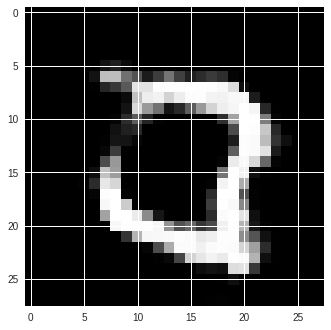

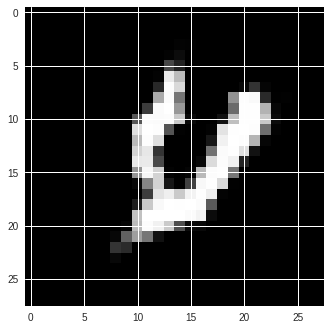

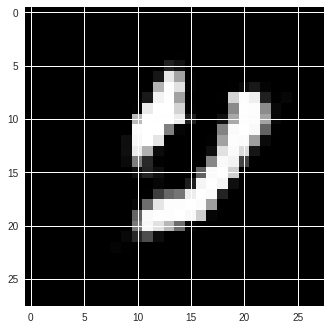

tensor(0.6798, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3272, device='cuda:0', grad_fn=<ThAddBackward>)
17th iteration gen_loss: 0.6798425316810608 dis_loss: 0.32717210054397583
tensor(0.5726, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2222, device='cuda:0', grad_fn=<ThAddBackward>)
17th iteration gen_loss: 0.5726233124732971 dis_loss: 0.2222006618976593
tensor(0.5637, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4214, device='cuda:0', grad_fn=<ThAddBackward>)
17th iteration gen_loss: 0.5636953711509705 dis_loss: 0.4214244484901428


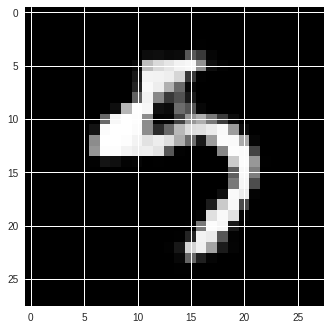

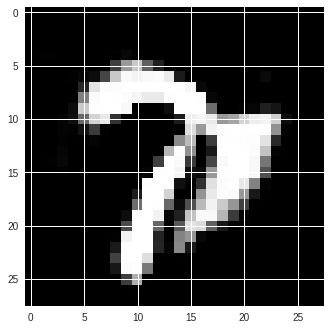

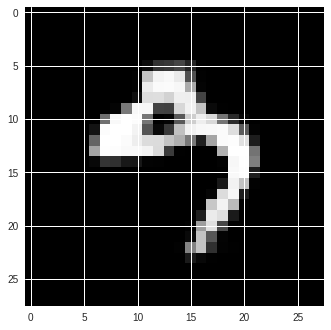

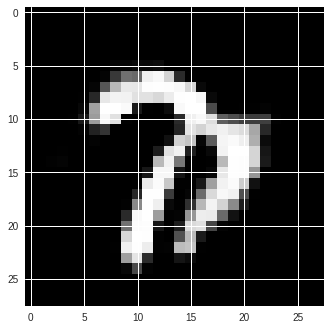

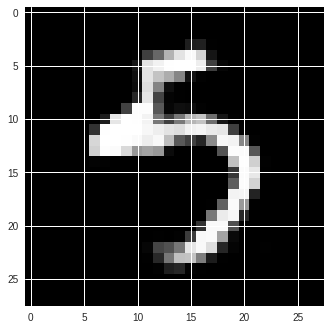

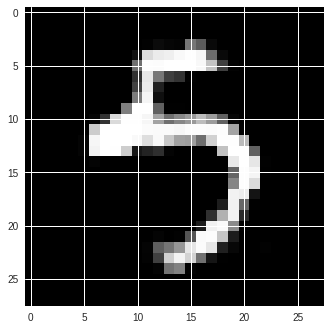

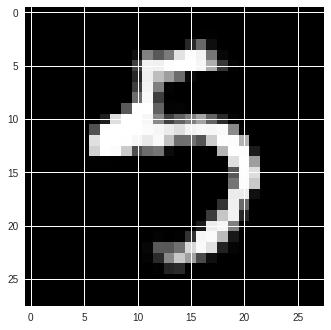

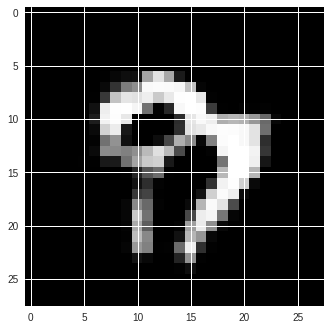

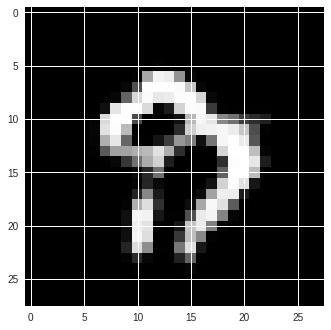

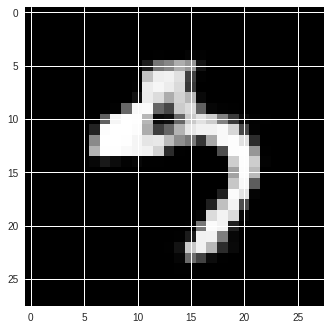

tensor(0.5130, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3091, device='cuda:0', grad_fn=<ThAddBackward>)
18th iteration gen_loss: 0.5129871368408203 dis_loss: 0.3090604543685913
tensor(0.4715, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2710, device='cuda:0', grad_fn=<ThAddBackward>)
18th iteration gen_loss: 0.4715445637702942 dis_loss: 0.27099746465682983
tensor(0.4897, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3226, device='cuda:0', grad_fn=<ThAddBackward>)
18th iteration gen_loss: 0.4897024631500244 dis_loss: 0.3226320743560791


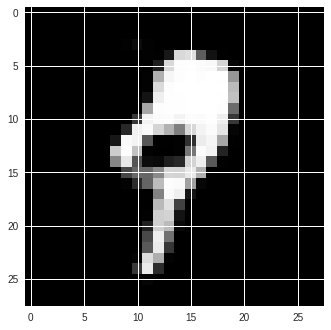

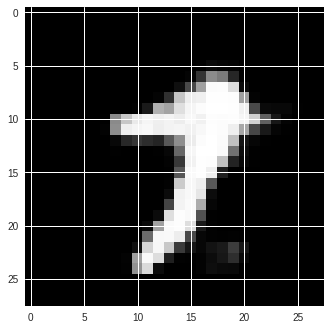

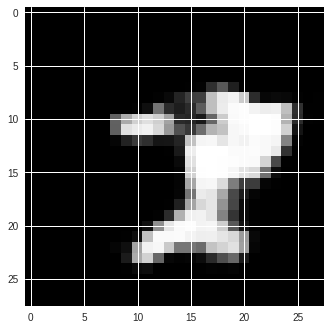

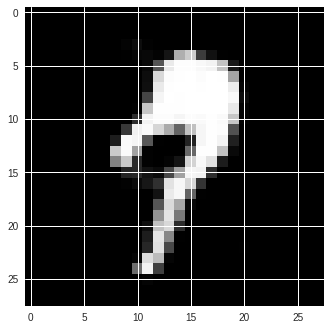

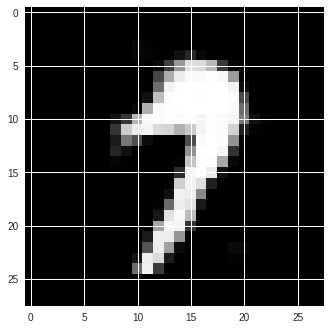

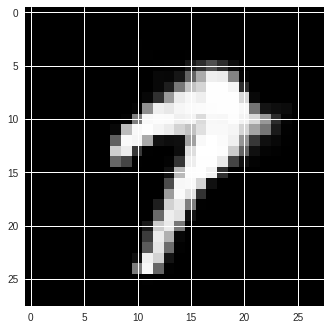

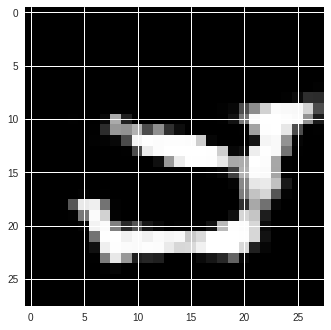

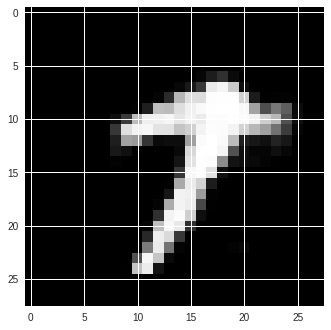

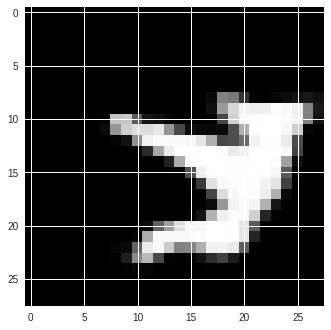

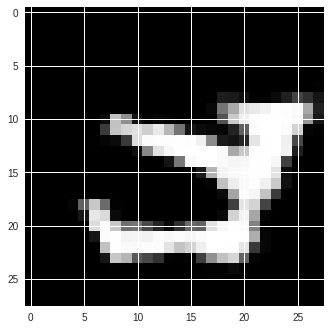

tensor(0.5292, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4126, device='cuda:0', grad_fn=<ThAddBackward>)
19th iteration gen_loss: 0.5291666388511658 dis_loss: 0.41255098581314087
tensor(0.6218, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2603, device='cuda:0', grad_fn=<ThAddBackward>)
19th iteration gen_loss: 0.6217803955078125 dis_loss: 0.26034221053123474
tensor(0.7208, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0661, device='cuda:0', grad_fn=<ThAddBackward>)
19th iteration gen_loss: 0.7208043336868286 dis_loss: 0.06605034321546555


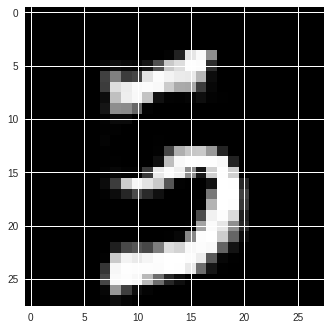

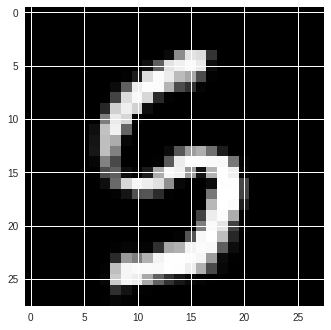

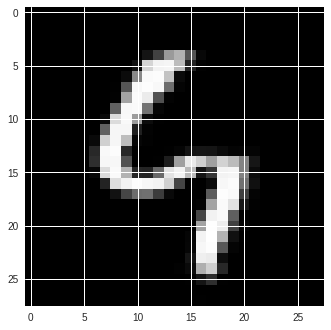

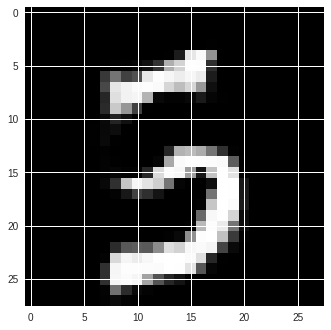

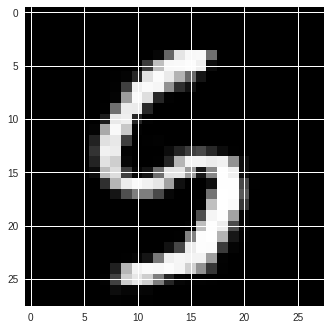

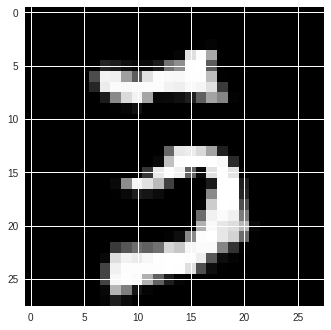

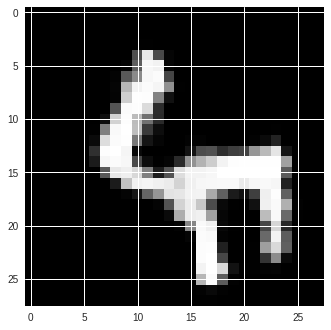

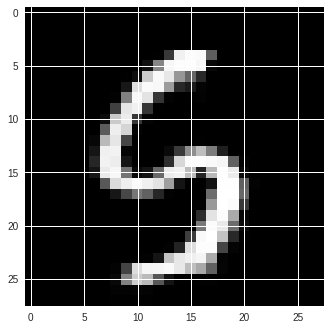

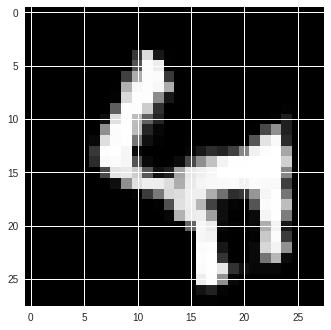

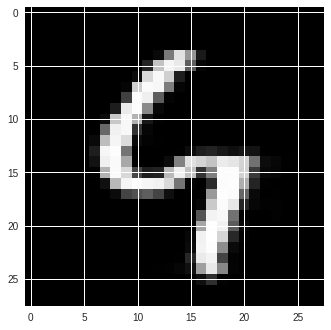

tensor(0.7778, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1394, device='cuda:0', grad_fn=<ThAddBackward>)
20th iteration gen_loss: 0.7777653336524963 dis_loss: 0.13940270245075226
tensor(0.6339, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1855, device='cuda:0', grad_fn=<ThAddBackward>)
20th iteration gen_loss: 0.6338878870010376 dis_loss: 0.18554258346557617
tensor(0.6440, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1822, device='cuda:0', grad_fn=<ThAddBackward>)
20th iteration gen_loss: 0.6439716815948486 dis_loss: 0.1822456419467926


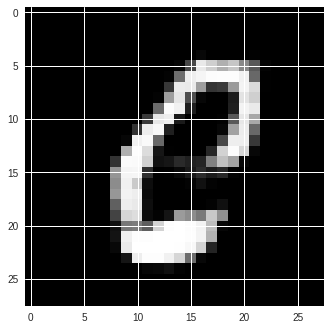

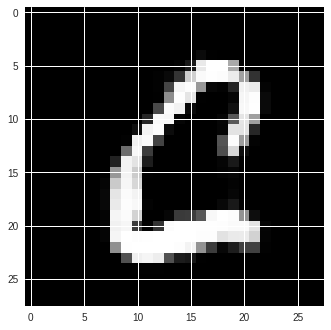

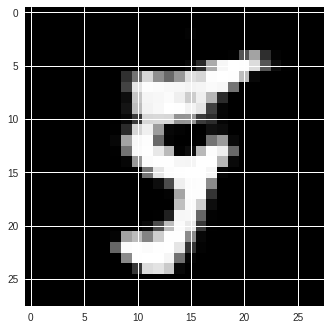

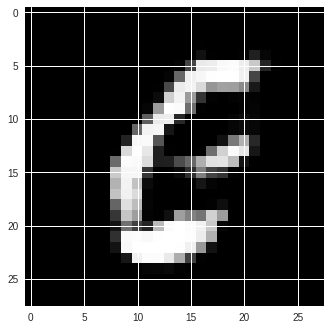

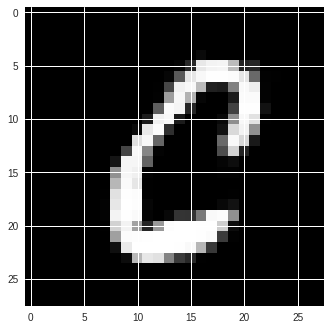

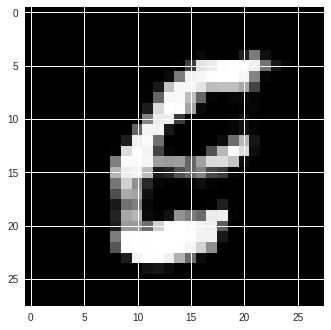

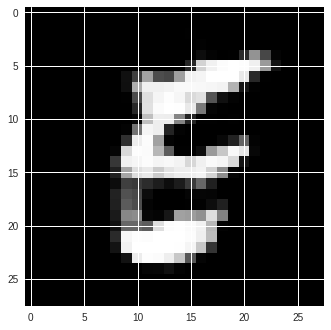

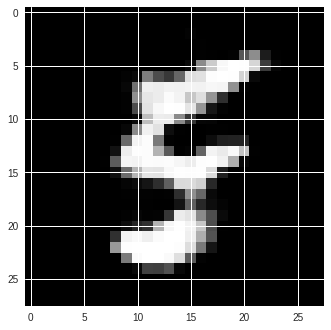

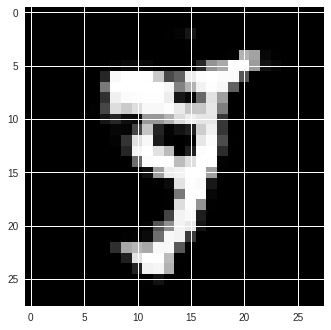

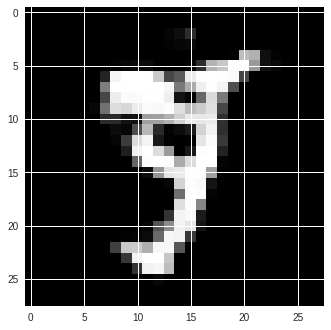

tensor(0.6523, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1360, device='cuda:0', grad_fn=<ThAddBackward>)
21th iteration gen_loss: 0.6523405909538269 dis_loss: 0.13603036105632782
tensor(0.6741, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1400, device='cuda:0', grad_fn=<ThAddBackward>)
21th iteration gen_loss: 0.6741412878036499 dis_loss: 0.14000897109508514
tensor(0.5816, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1599, device='cuda:0', grad_fn=<ThAddBackward>)
21th iteration gen_loss: 0.5815844535827637 dis_loss: 0.15989980101585388


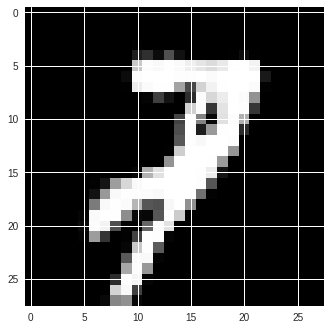

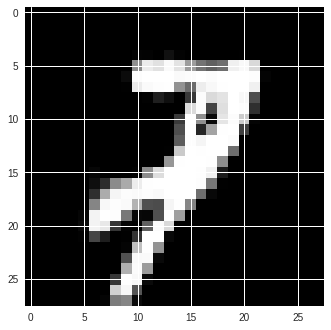

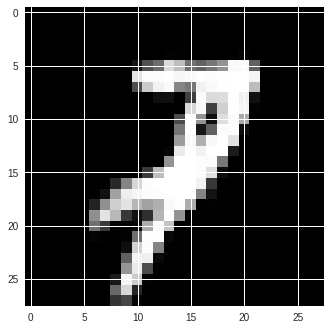

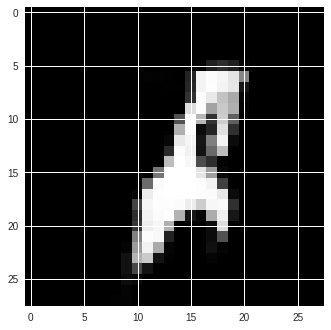

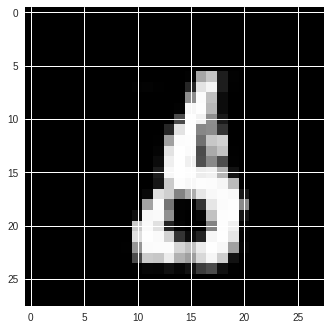

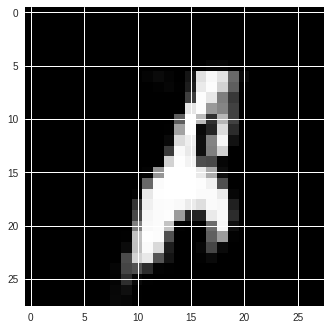

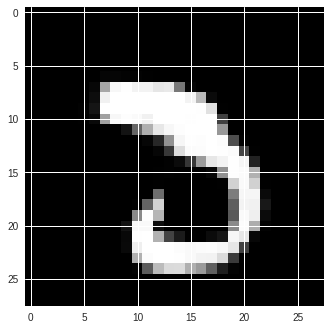

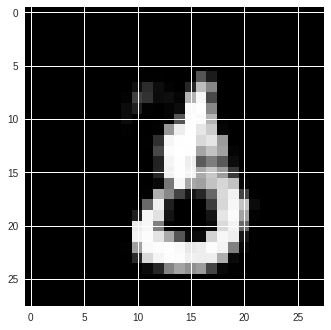

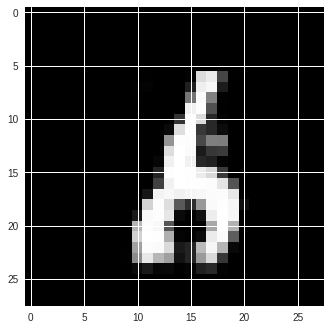

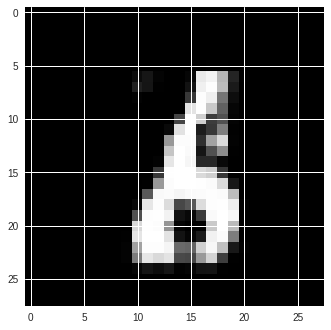

tensor(0.5183, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2700, device='cuda:0', grad_fn=<ThAddBackward>)
22th iteration gen_loss: 0.5183117389678955 dis_loss: 0.27003300189971924
tensor(0.6607, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1936, device='cuda:0', grad_fn=<ThAddBackward>)
22th iteration gen_loss: 0.6606703996658325 dis_loss: 0.19362181425094604
tensor(0.6067, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2954, device='cuda:0', grad_fn=<ThAddBackward>)
22th iteration gen_loss: 0.6067429780960083 dis_loss: 0.2954293191432953


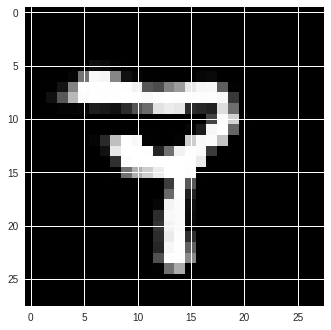

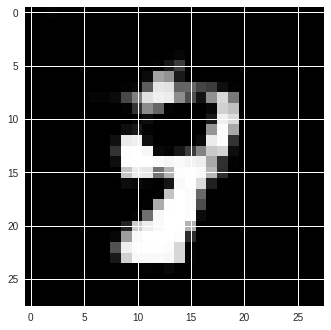

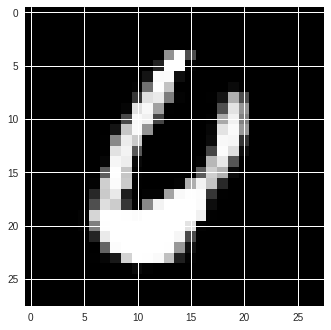

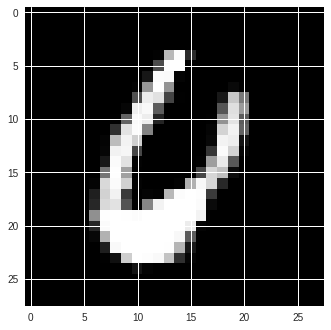

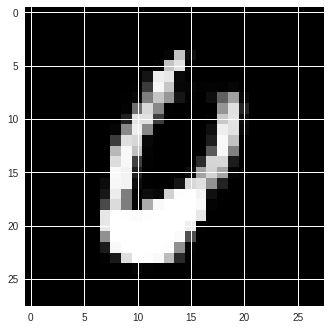

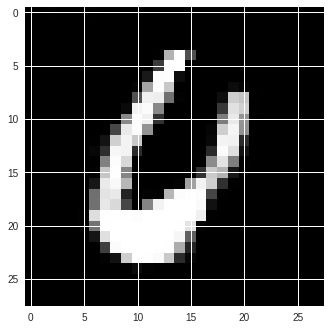

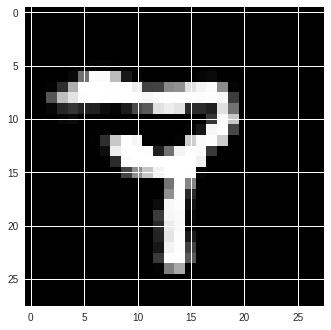

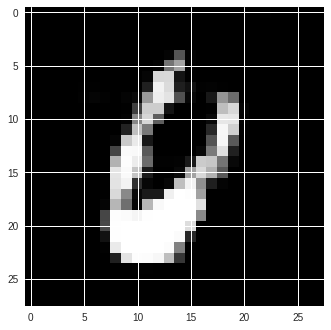

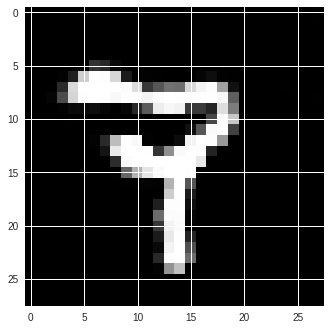

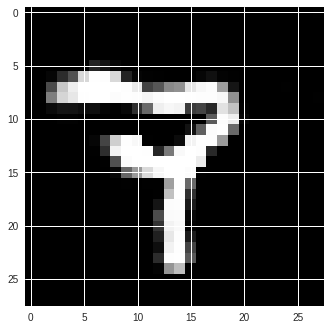

tensor(0.6267, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2043, device='cuda:0', grad_fn=<ThAddBackward>)
23th iteration gen_loss: 0.6266764402389526 dis_loss: 0.2042996883392334
tensor(0.6999, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0985, device='cuda:0', grad_fn=<ThAddBackward>)
23th iteration gen_loss: 0.6999490261077881 dis_loss: 0.09848403930664062
tensor(0.5016, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.5223, device='cuda:0', grad_fn=<ThAddBackward>)
23th iteration gen_loss: 0.5016350746154785 dis_loss: 0.5223425030708313


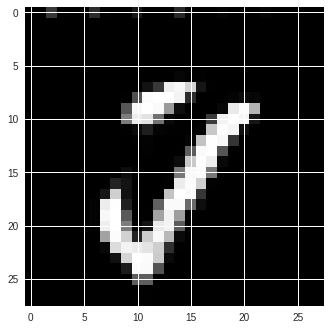

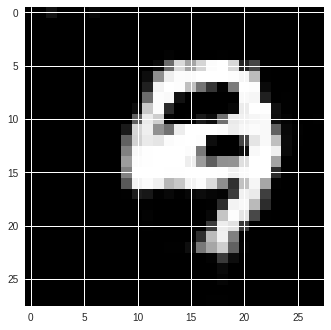

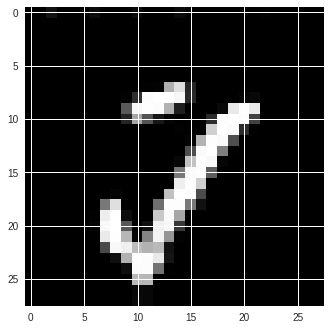

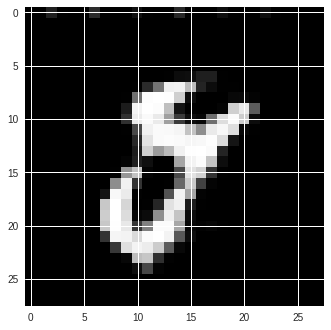

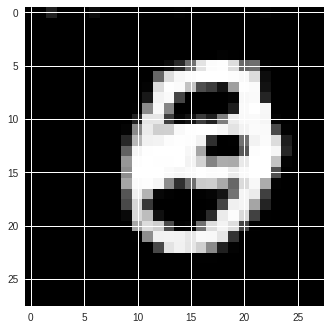

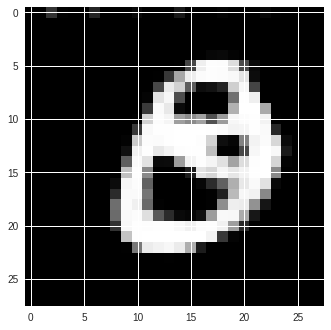

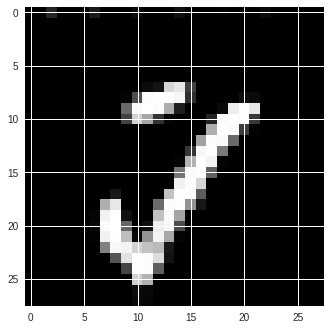

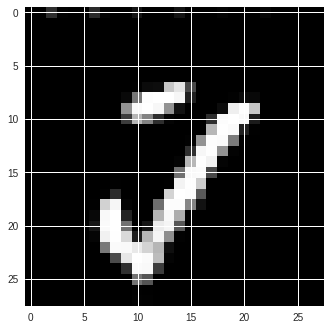

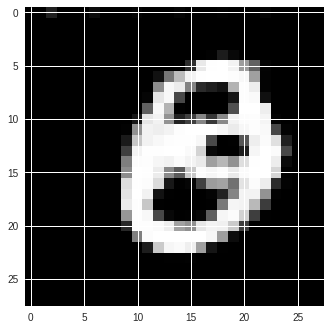

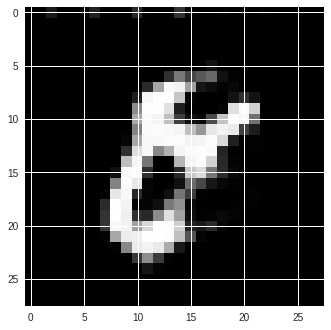

tensor(0.6382, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2263, device='cuda:0', grad_fn=<ThAddBackward>)
24th iteration gen_loss: 0.6382130980491638 dis_loss: 0.2262789011001587
tensor(0.6444, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2824, device='cuda:0', grad_fn=<ThAddBackward>)
24th iteration gen_loss: 0.6443595290184021 dis_loss: 0.28244614601135254
tensor(0.7163, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2477, device='cuda:0', grad_fn=<ThAddBackward>)
24th iteration gen_loss: 0.7163188457489014 dis_loss: 0.24774955213069916


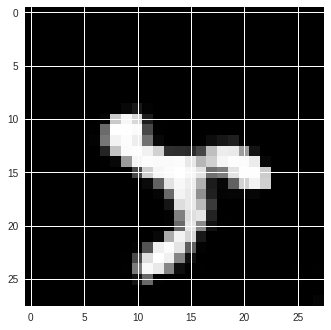

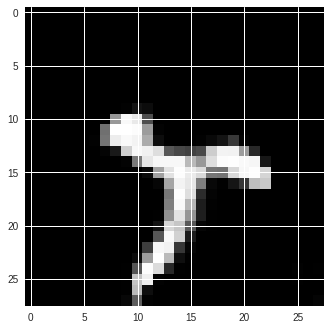

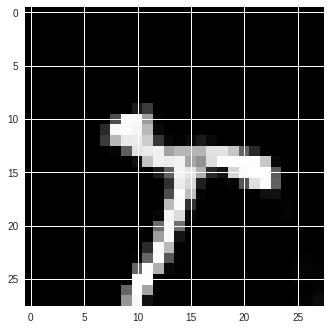

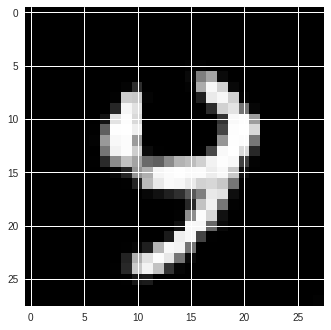

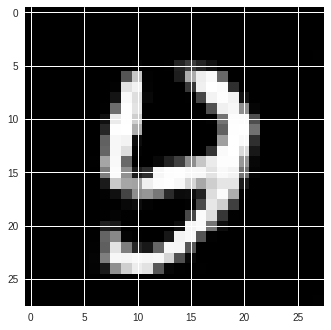

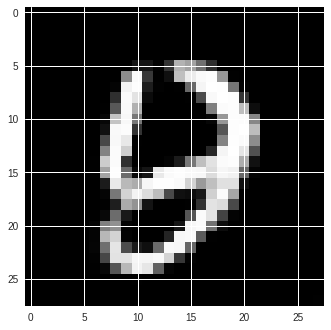

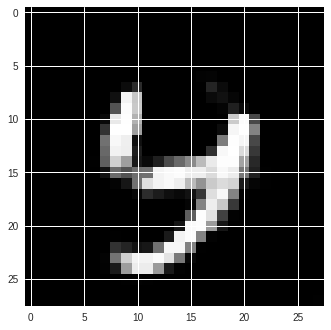

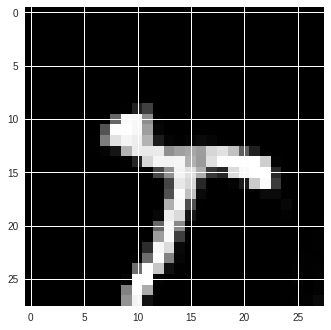

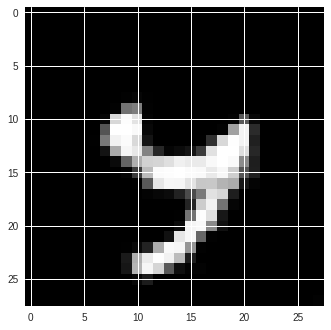

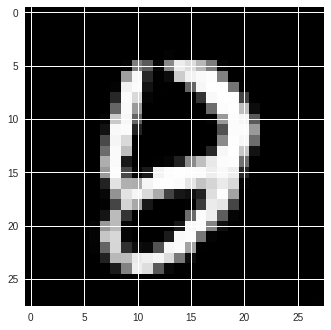

tensor(0.7195, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0934, device='cuda:0', grad_fn=<ThAddBackward>)
25th iteration gen_loss: 0.7194519639015198 dis_loss: 0.0934114158153534
tensor(0.6762, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2722, device='cuda:0', grad_fn=<ThAddBackward>)
25th iteration gen_loss: 0.6762357354164124 dis_loss: 0.27216455340385437
tensor(0.7401, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0770, device='cuda:0', grad_fn=<ThAddBackward>)
25th iteration gen_loss: 0.7400801777839661 dis_loss: 0.07702610641717911


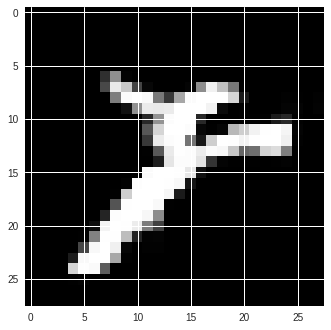

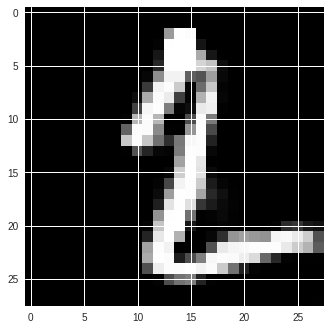

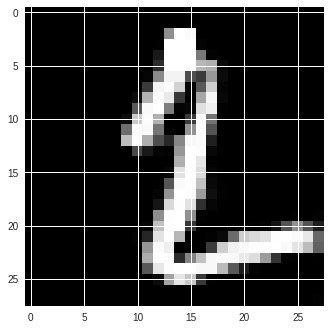

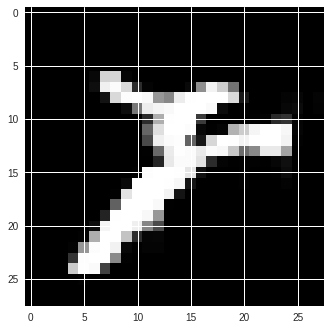

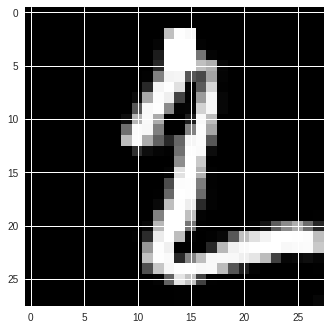

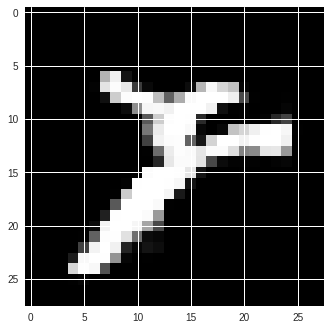

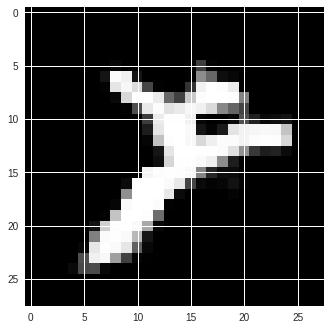

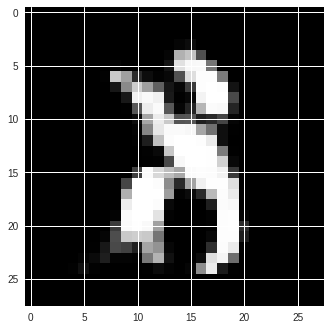

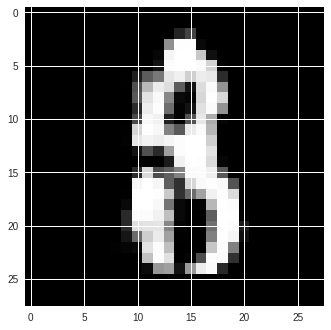

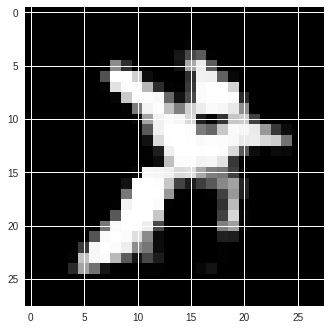

tensor(0.6565, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2270, device='cuda:0', grad_fn=<ThAddBackward>)
26th iteration gen_loss: 0.6564879417419434 dis_loss: 0.22702133655548096
tensor(0.6936, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1057, device='cuda:0', grad_fn=<ThAddBackward>)
26th iteration gen_loss: 0.6936454176902771 dis_loss: 0.10571493208408356
tensor(0.5149, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4987, device='cuda:0', grad_fn=<ThAddBackward>)
26th iteration gen_loss: 0.5148866176605225 dis_loss: 0.4986538887023926


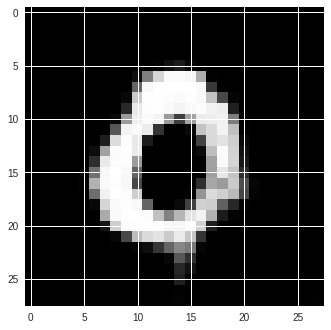

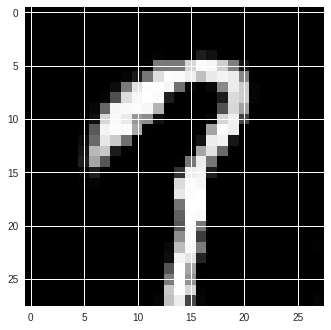

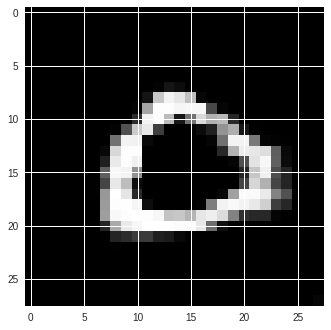

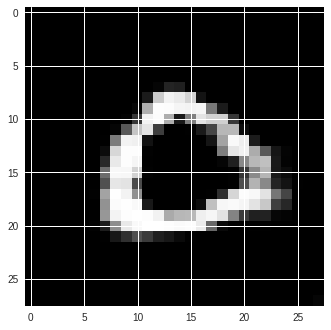

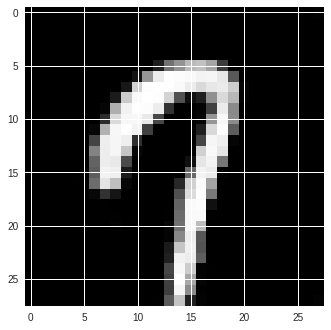

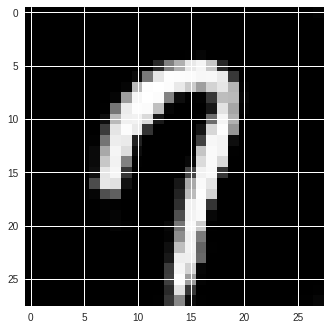

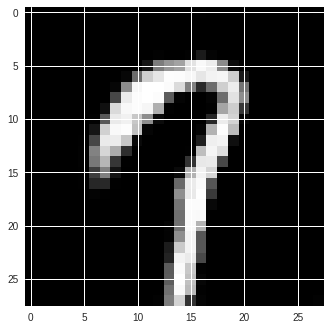

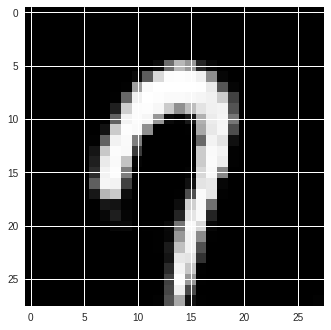

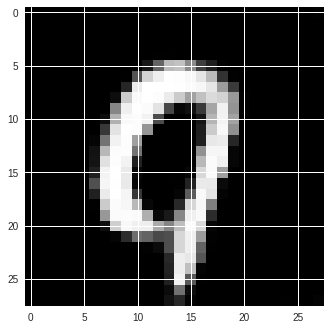

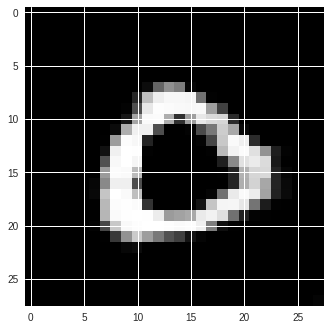

tensor(0.6625, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3936, device='cuda:0', grad_fn=<ThAddBackward>)
27th iteration gen_loss: 0.6624850034713745 dis_loss: 0.39362868666648865
tensor(0.6493, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2265, device='cuda:0', grad_fn=<ThAddBackward>)
27th iteration gen_loss: 0.6493428349494934 dis_loss: 0.22652289271354675
tensor(0.7531, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1020, device='cuda:0', grad_fn=<ThAddBackward>)
27th iteration gen_loss: 0.7531270980834961 dis_loss: 0.10204252600669861


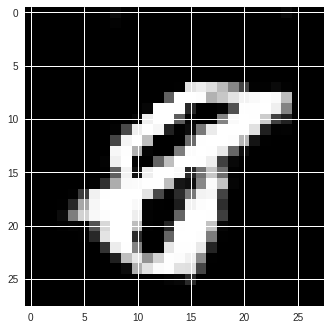

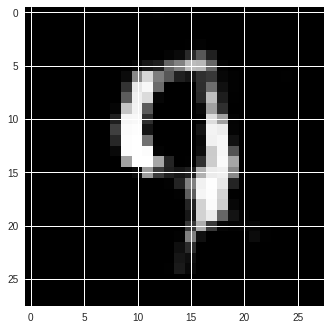

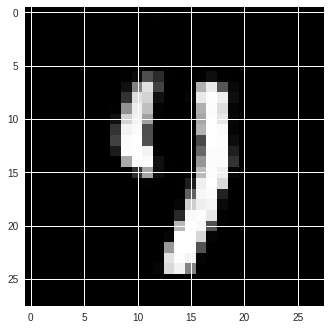

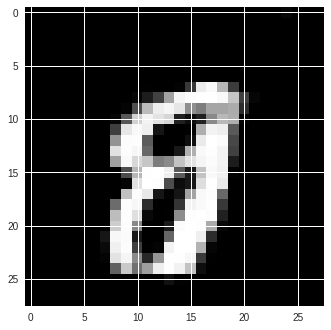

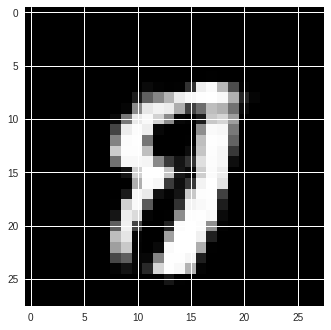

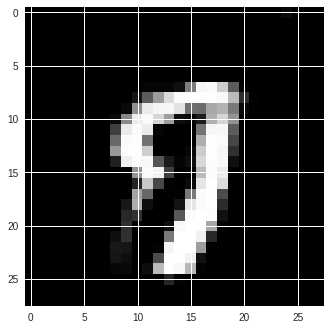

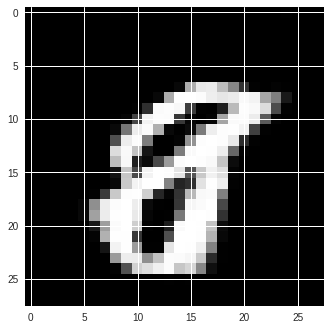

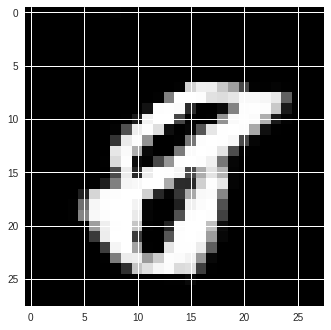

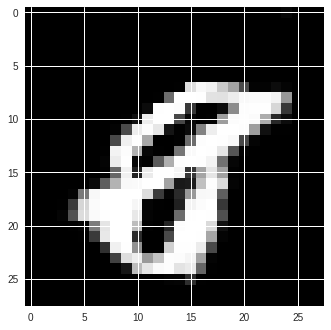

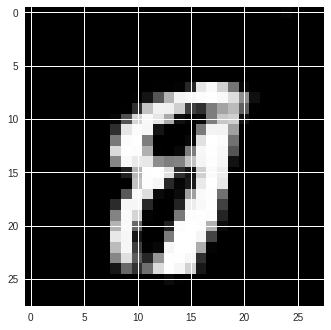

tensor(0.6415, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1754, device='cuda:0', grad_fn=<ThAddBackward>)
28th iteration gen_loss: 0.6415087580680847 dis_loss: 0.1753634661436081
tensor(0.5956, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2203, device='cuda:0', grad_fn=<ThAddBackward>)
28th iteration gen_loss: 0.5955974459648132 dis_loss: 0.22027742862701416
tensor(0.7158, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1877, device='cuda:0', grad_fn=<ThAddBackward>)
28th iteration gen_loss: 0.7158244848251343 dis_loss: 0.18772539496421814


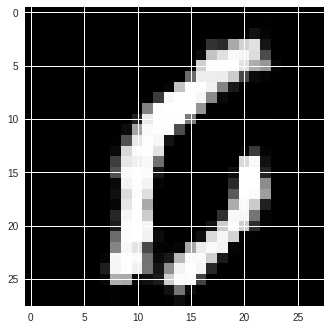

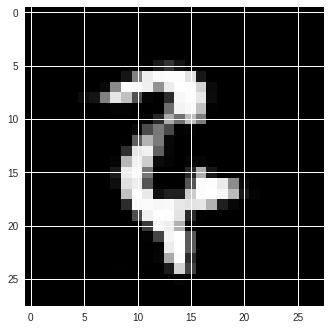

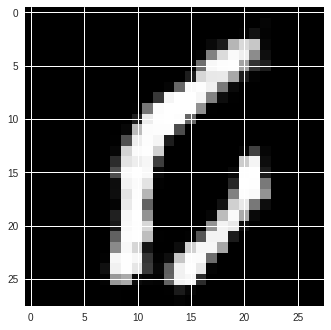

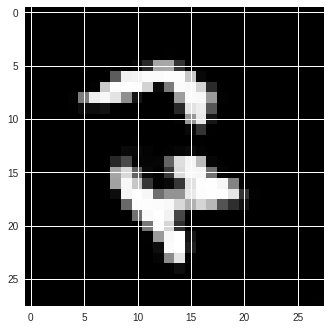

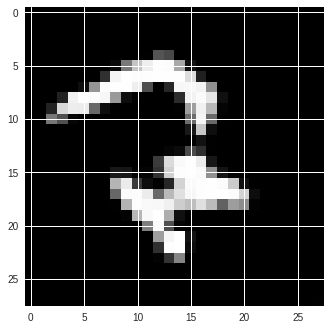

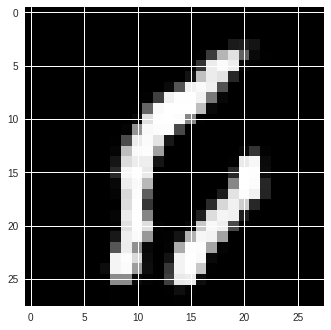

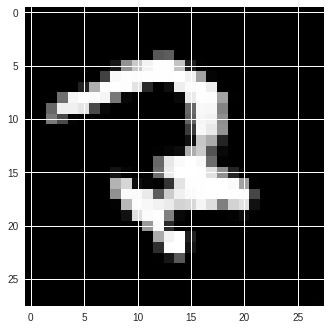

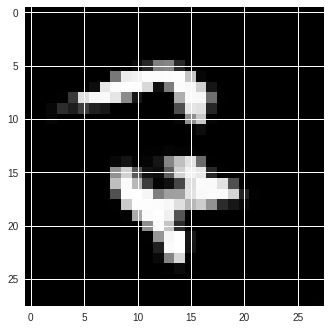

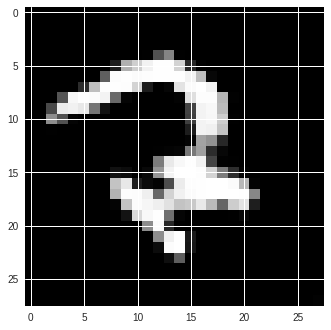

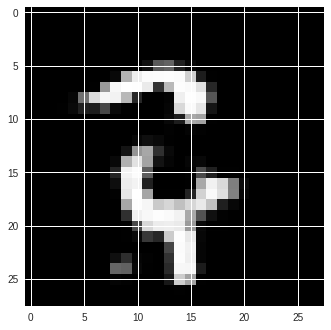

tensor(0.6260, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1370, device='cuda:0', grad_fn=<ThAddBackward>)
29th iteration gen_loss: 0.6259974241256714 dis_loss: 0.13703405857086182
tensor(0.4961, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3143, device='cuda:0', grad_fn=<ThAddBackward>)
29th iteration gen_loss: 0.4960930049419403 dis_loss: 0.31427380442619324
tensor(0.6438, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1858, device='cuda:0', grad_fn=<ThAddBackward>)
29th iteration gen_loss: 0.6437696814537048 dis_loss: 0.18580707907676697


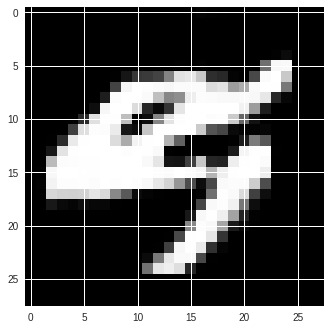

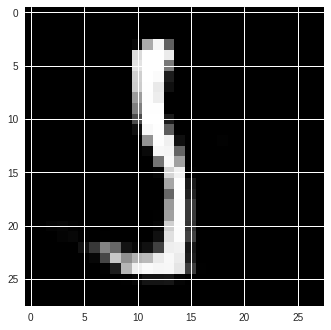

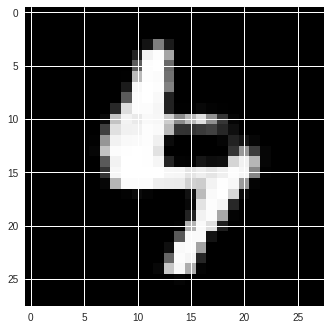

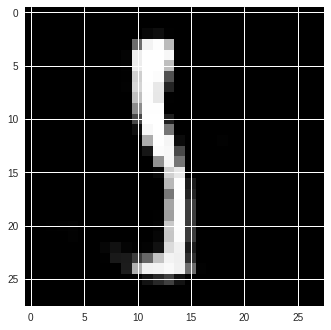

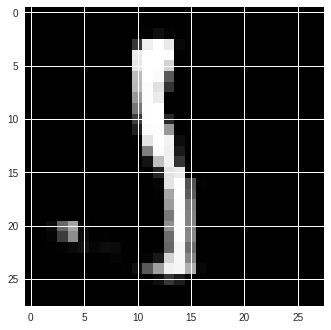

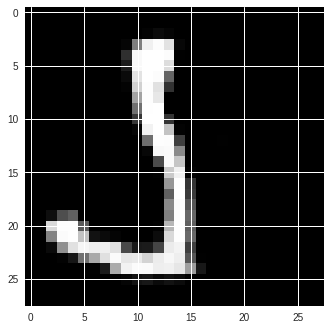

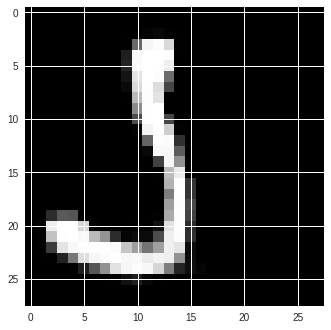

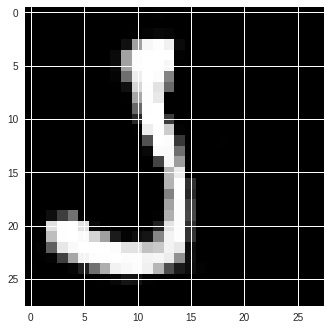

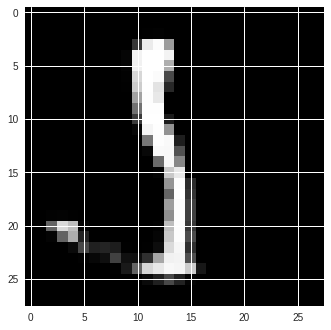

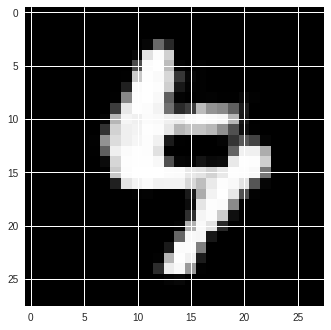

tensor(0.6847, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1923, device='cuda:0', grad_fn=<ThAddBackward>)
30th iteration gen_loss: 0.6846713423728943 dis_loss: 0.19233402609825134
tensor(0.6634, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1864, device='cuda:0', grad_fn=<ThAddBackward>)
30th iteration gen_loss: 0.6634107828140259 dis_loss: 0.18636780977249146
tensor(0.5845, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2604, device='cuda:0', grad_fn=<ThAddBackward>)
30th iteration gen_loss: 0.5845449566841125 dis_loss: 0.2603704631328583


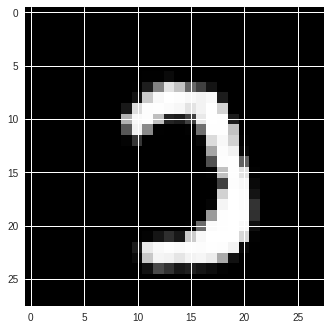

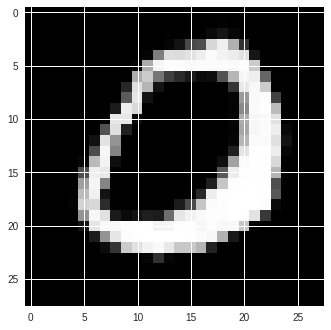

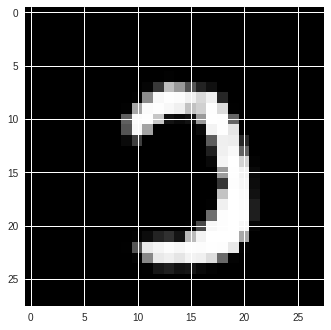

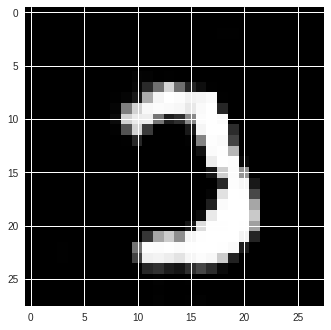

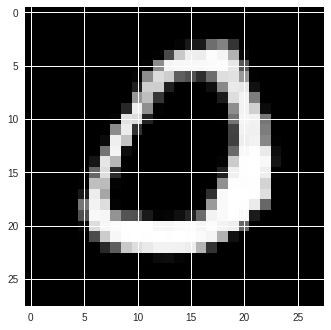

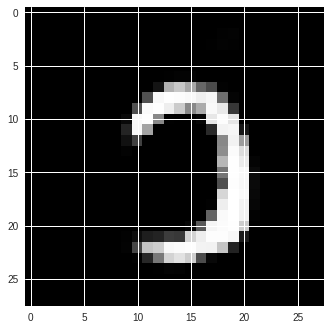

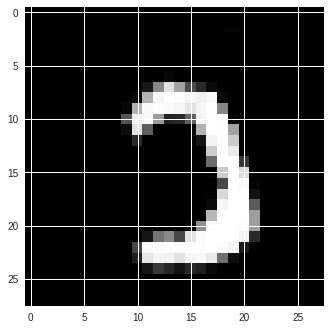

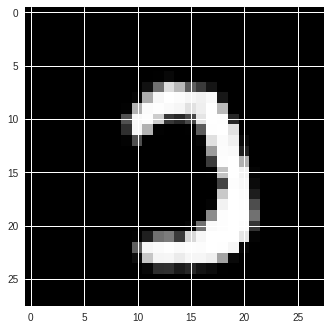

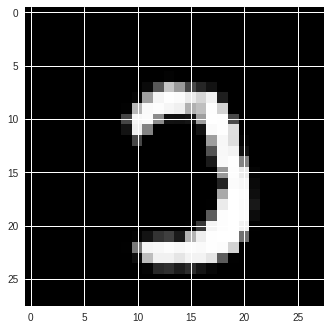

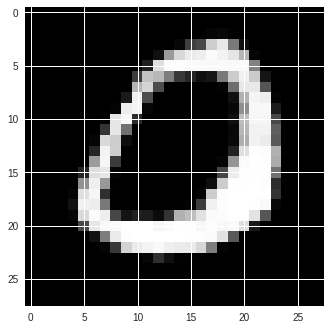

tensor(0.6854, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.6526, device='cuda:0', grad_fn=<ThAddBackward>)
31th iteration gen_loss: 0.6853541731834412 dis_loss: 0.6525713205337524
tensor(0.5737, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3350, device='cuda:0', grad_fn=<ThAddBackward>)
31th iteration gen_loss: 0.5737149715423584 dis_loss: 0.33498597145080566
tensor(0.6082, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3415, device='cuda:0', grad_fn=<ThAddBackward>)
31th iteration gen_loss: 0.6081921458244324 dis_loss: 0.3414596617221832


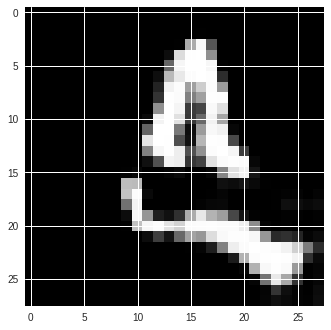

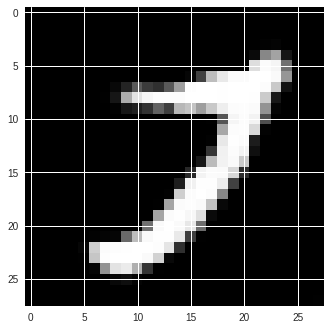

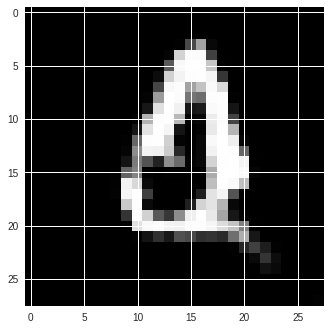

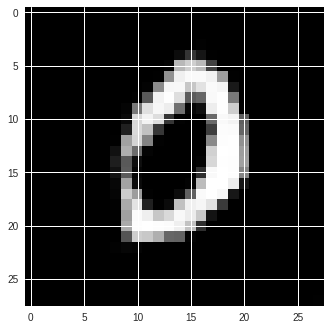

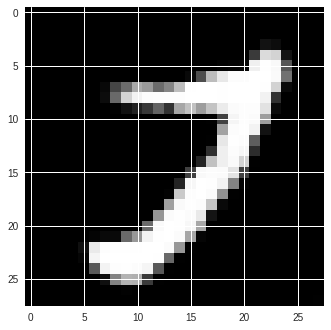

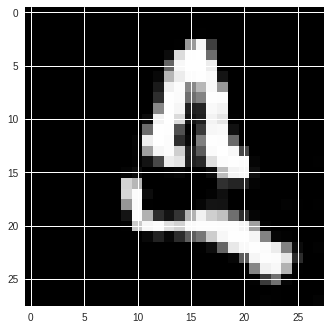

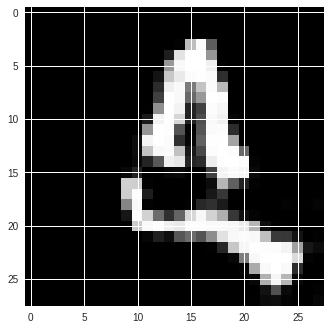

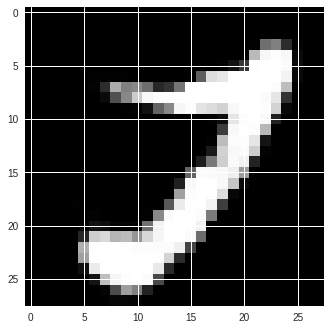

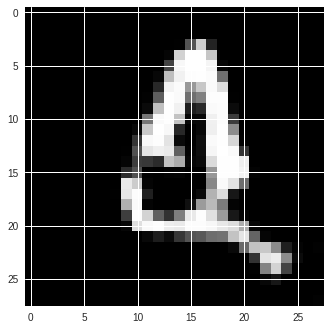

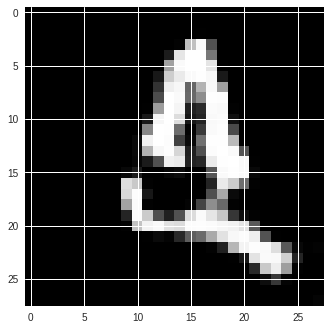

tensor(0.6013, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3373, device='cuda:0', grad_fn=<ThAddBackward>)
32th iteration gen_loss: 0.6013232469558716 dis_loss: 0.3373132348060608
tensor(0.6424, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1497, device='cuda:0', grad_fn=<ThAddBackward>)
32th iteration gen_loss: 0.6424325704574585 dis_loss: 0.1497136354446411
tensor(0.6205, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1916, device='cuda:0', grad_fn=<ThAddBackward>)
32th iteration gen_loss: 0.6204792857170105 dis_loss: 0.19157370924949646


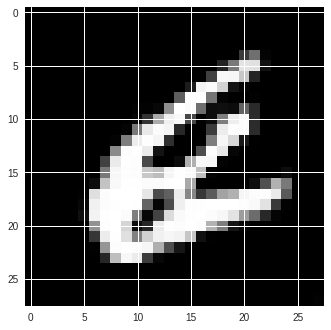

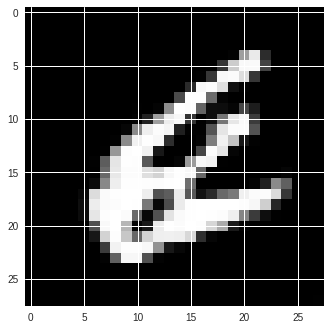

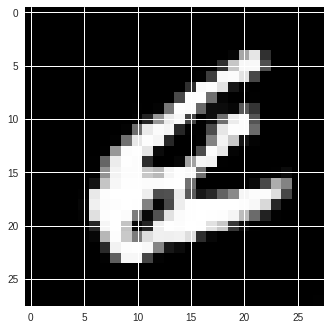

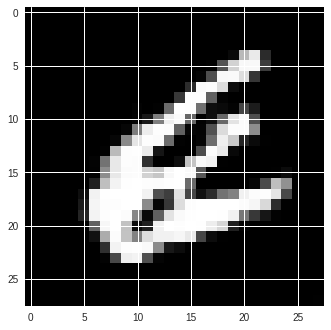

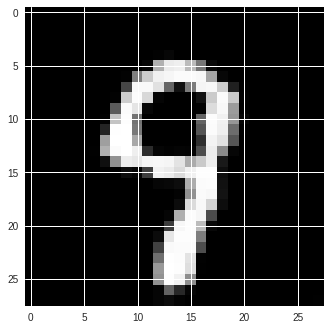

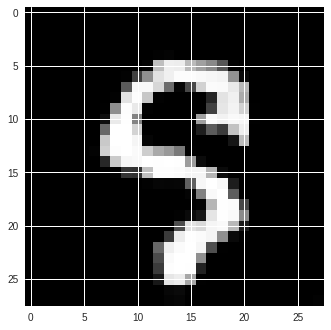

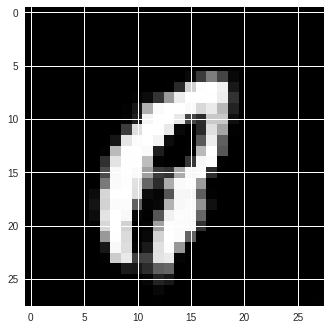

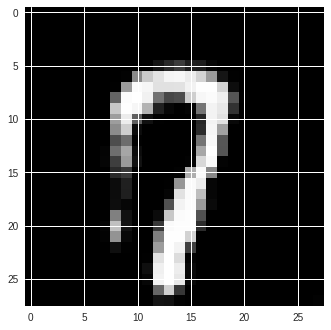

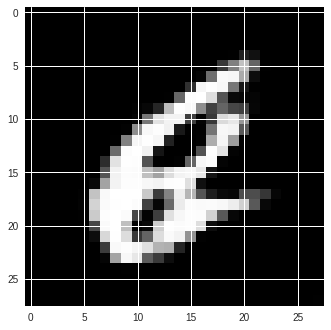

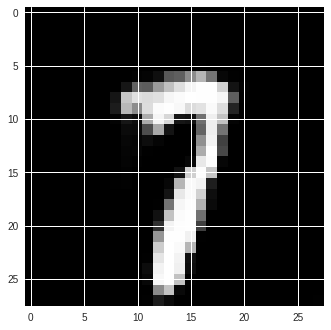

tensor(0.6326, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3186, device='cuda:0', grad_fn=<ThAddBackward>)
33th iteration gen_loss: 0.6326116919517517 dis_loss: 0.3185526132583618
tensor(0.4155, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2348, device='cuda:0', grad_fn=<ThAddBackward>)
33th iteration gen_loss: 0.4154618978500366 dis_loss: 0.2348446100950241
tensor(0.6735, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2887, device='cuda:0', grad_fn=<ThAddBackward>)
33th iteration gen_loss: 0.6735299229621887 dis_loss: 0.2886776626110077


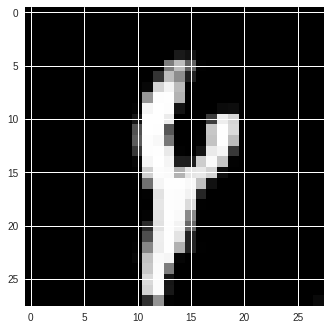

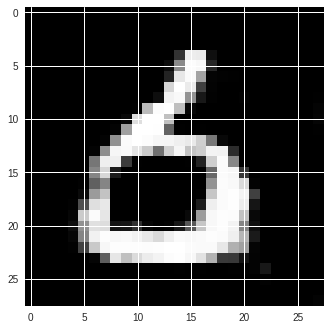

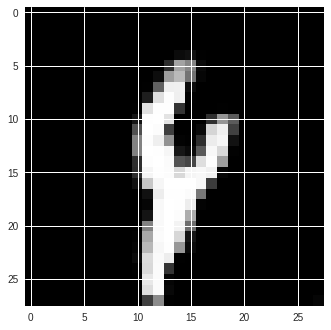

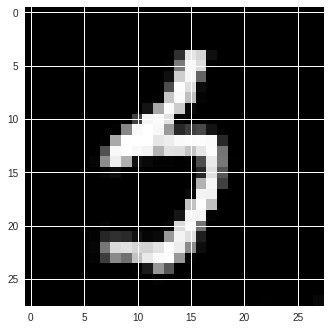

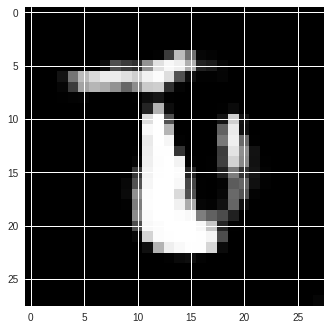

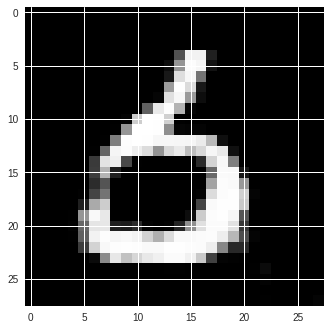

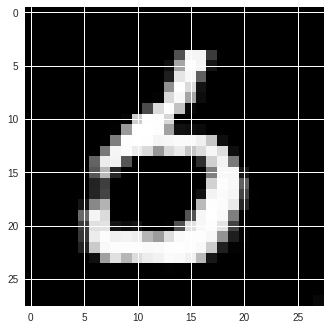

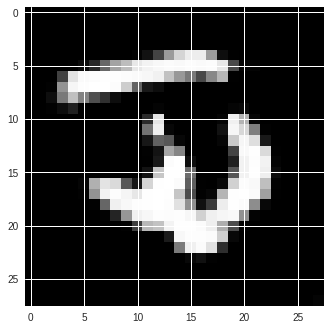

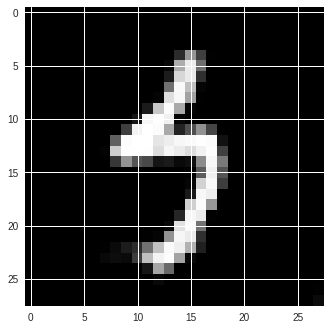

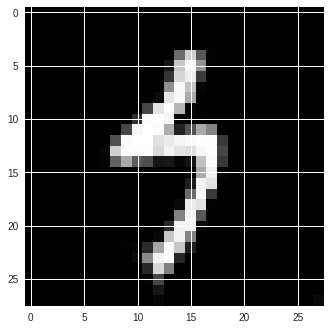

tensor(0.6216, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2412, device='cuda:0', grad_fn=<ThAddBackward>)
34th iteration gen_loss: 0.6215674877166748 dis_loss: 0.24115528166294098
tensor(0.5245, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2990, device='cuda:0', grad_fn=<ThAddBackward>)
34th iteration gen_loss: 0.5245046019554138 dis_loss: 0.299031138420105
tensor(0.5671, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3118, device='cuda:0', grad_fn=<ThAddBackward>)
34th iteration gen_loss: 0.5671063661575317 dis_loss: 0.3117695450782776


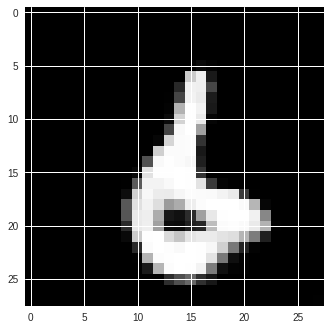

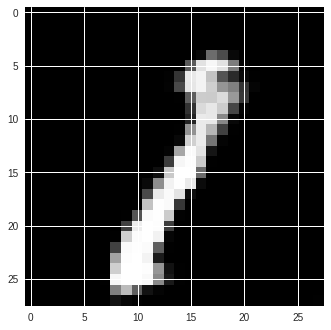

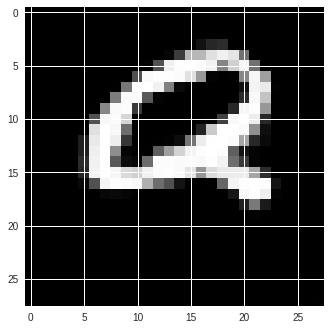

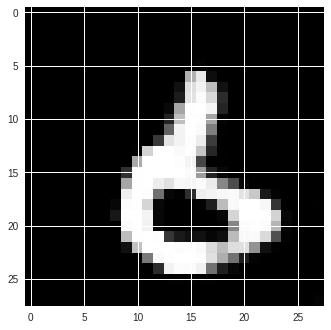

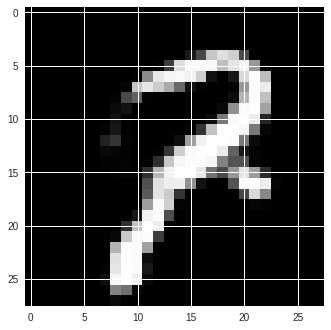

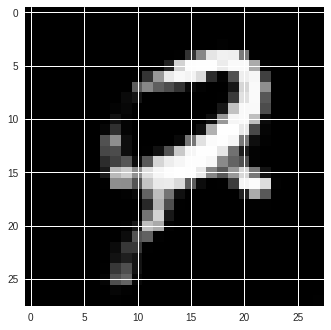

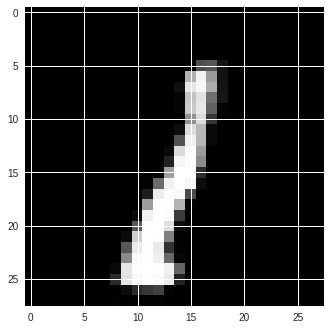

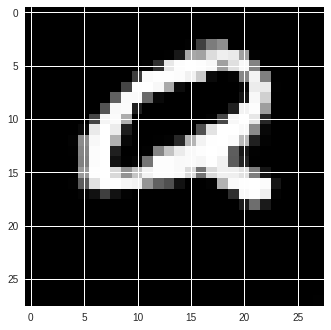

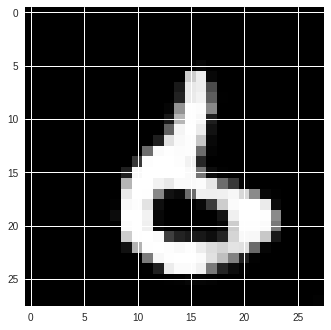

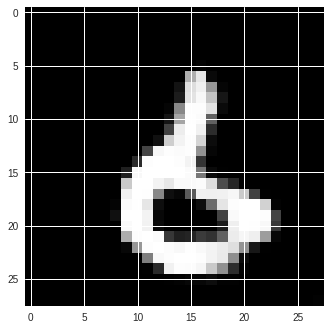

tensor(0.6295, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3082, device='cuda:0', grad_fn=<ThAddBackward>)
35th iteration gen_loss: 0.6295043230056763 dis_loss: 0.30822426080703735
tensor(0.6111, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1999, device='cuda:0', grad_fn=<ThAddBackward>)
35th iteration gen_loss: 0.6110934615135193 dis_loss: 0.19985142350196838
tensor(0.5395, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4490, device='cuda:0', grad_fn=<ThAddBackward>)
35th iteration gen_loss: 0.5395447611808777 dis_loss: 0.44904667139053345


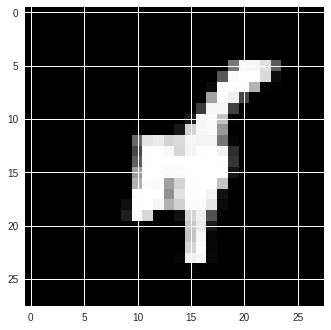

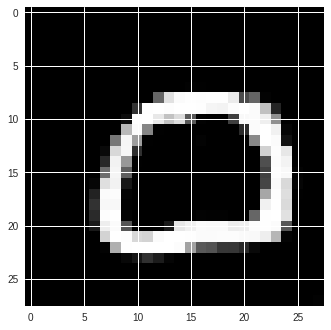

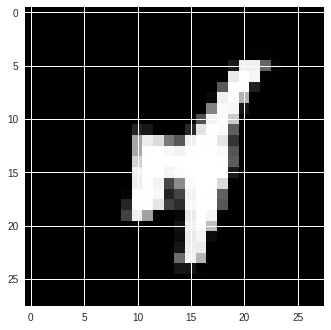

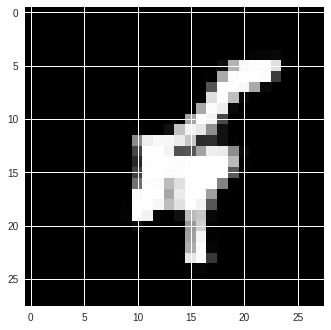

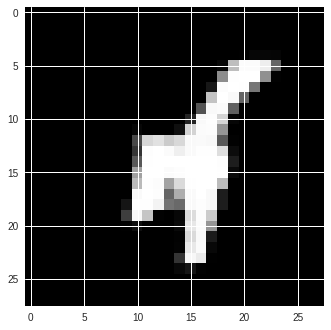

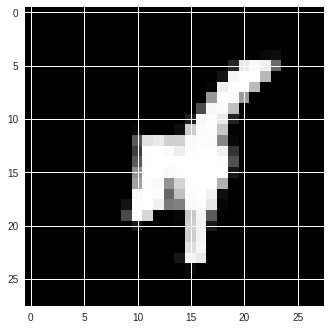

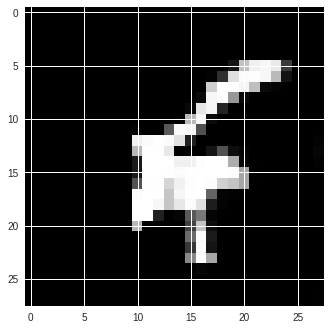

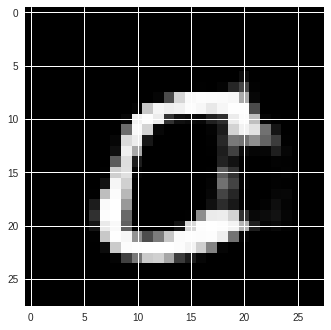

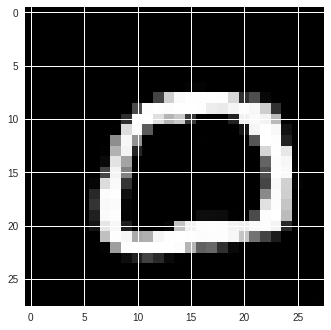

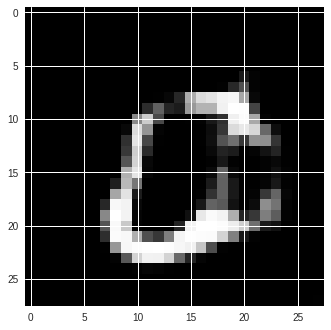

tensor(0.7233, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4690, device='cuda:0', grad_fn=<ThAddBackward>)
36th iteration gen_loss: 0.7232578992843628 dis_loss: 0.46899378299713135
tensor(0.7625, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1204, device='cuda:0', grad_fn=<ThAddBackward>)
36th iteration gen_loss: 0.7624508738517761 dis_loss: 0.12037330120801926
tensor(0.7870, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0907, device='cuda:0', grad_fn=<ThAddBackward>)
36th iteration gen_loss: 0.7869851589202881 dis_loss: 0.09065169095993042


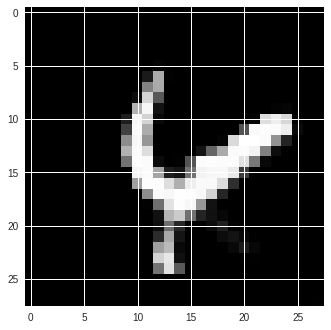

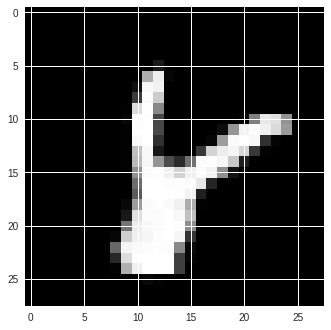

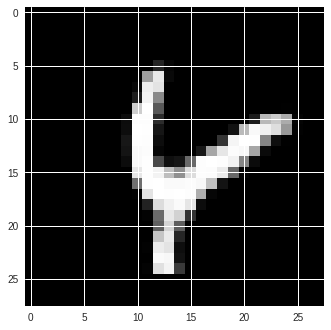

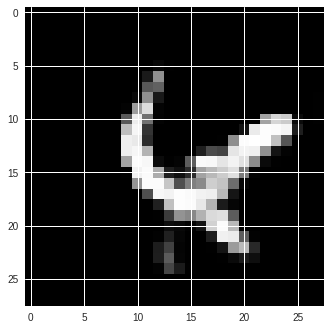

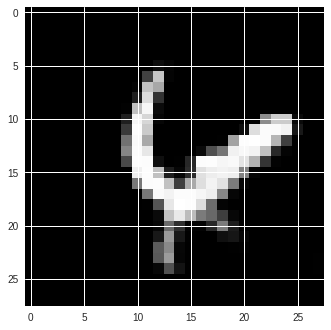

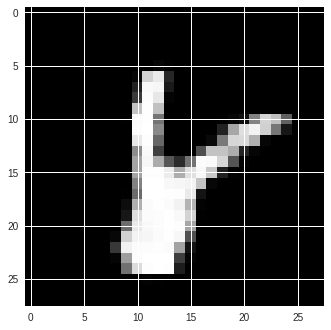

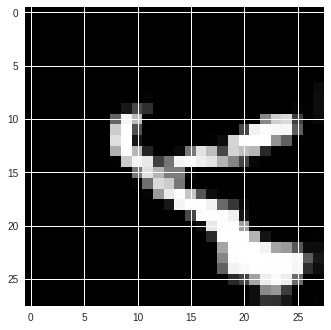

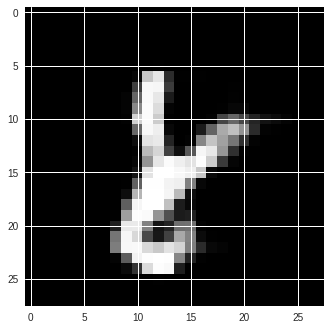

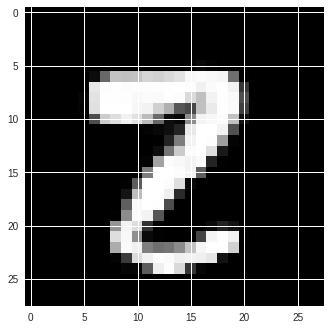

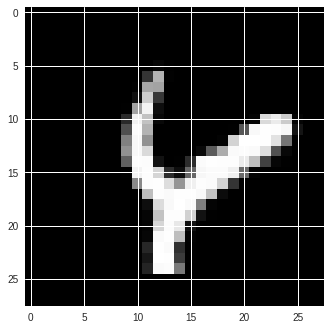

tensor(0.7391, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0951, device='cuda:0', grad_fn=<ThAddBackward>)
37th iteration gen_loss: 0.7391140460968018 dis_loss: 0.09507714211940765
tensor(0.6424, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2865, device='cuda:0', grad_fn=<ThAddBackward>)
37th iteration gen_loss: 0.6423605680465698 dis_loss: 0.2864764928817749
tensor(0.6086, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2527, device='cuda:0', grad_fn=<ThAddBackward>)
37th iteration gen_loss: 0.6086164712905884 dis_loss: 0.2526572346687317


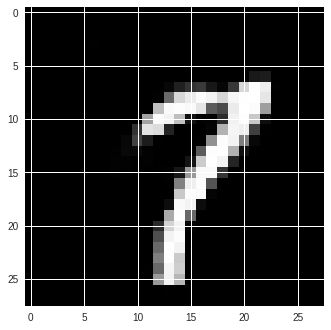

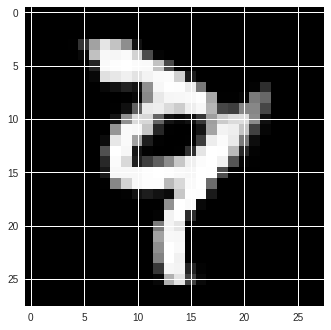

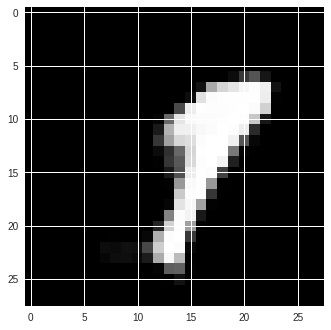

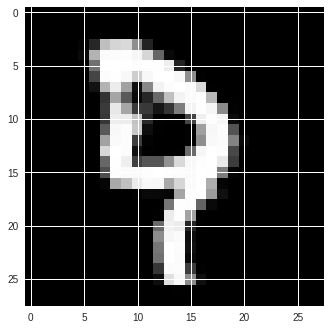

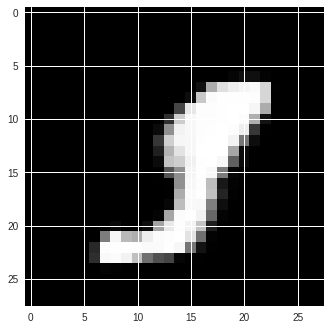

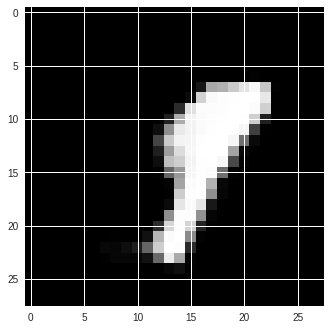

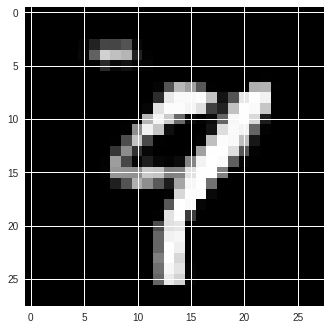

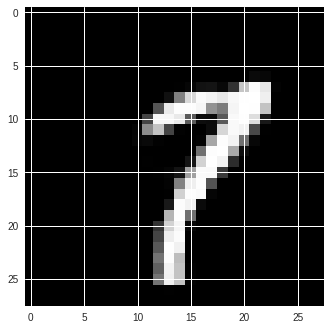

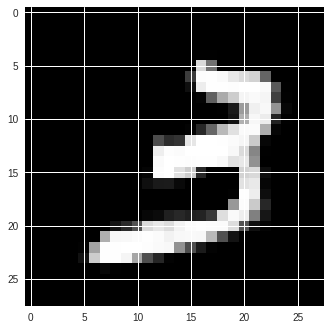

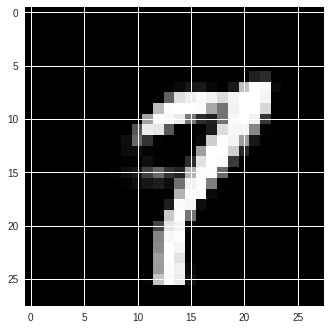

tensor(0.6313, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1498, device='cuda:0', grad_fn=<ThAddBackward>)
38th iteration gen_loss: 0.6313027143478394 dis_loss: 0.14978890120983124
tensor(0.5996, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2105, device='cuda:0', grad_fn=<ThAddBackward>)
38th iteration gen_loss: 0.5996339321136475 dis_loss: 0.21046681702136993
tensor(0.6640, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2266, device='cuda:0', grad_fn=<ThAddBackward>)
38th iteration gen_loss: 0.6639504432678223 dis_loss: 0.22658561170101166


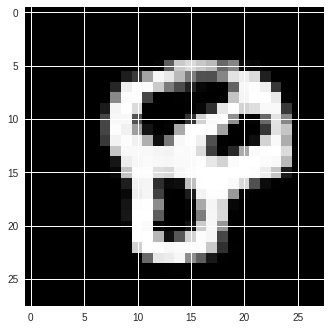

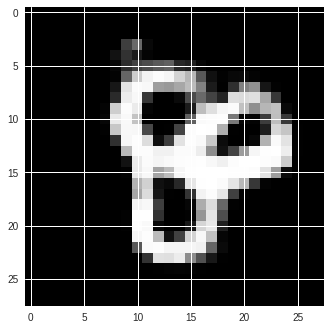

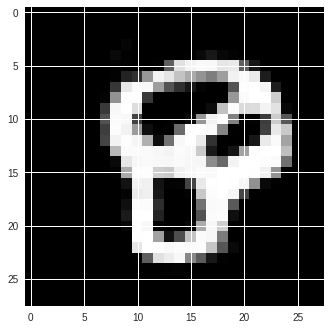

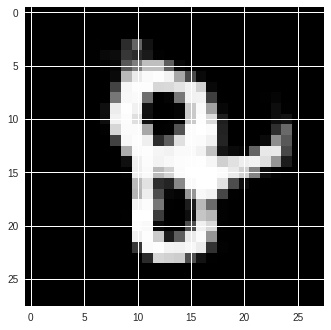

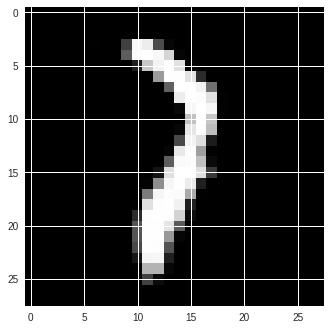

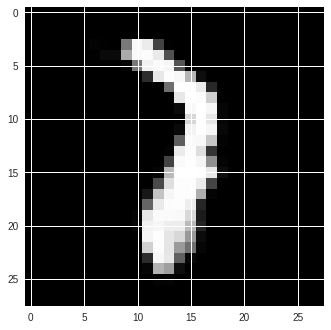

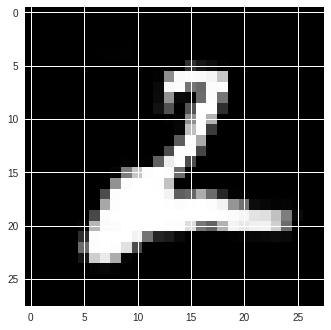

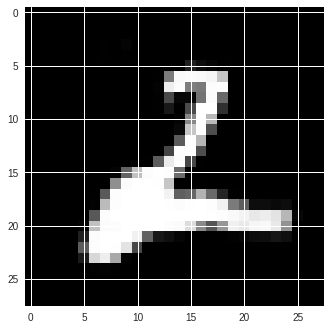

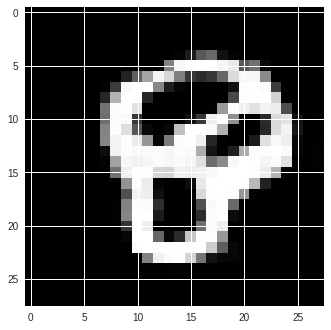

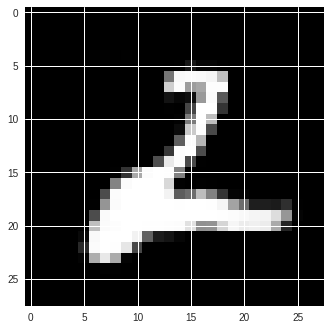

tensor(0.6340, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2598, device='cuda:0', grad_fn=<ThAddBackward>)
39th iteration gen_loss: 0.6340453624725342 dis_loss: 0.2598160207271576
tensor(0.6283, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2129, device='cuda:0', grad_fn=<ThAddBackward>)
39th iteration gen_loss: 0.6282739043235779 dis_loss: 0.2129065990447998
tensor(0.5718, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2707, device='cuda:0', grad_fn=<ThAddBackward>)
39th iteration gen_loss: 0.5718082785606384 dis_loss: 0.2707468569278717


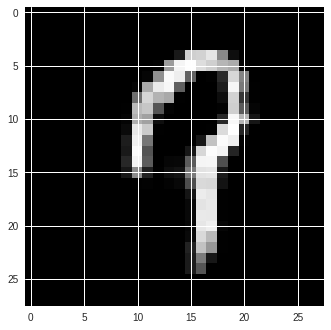

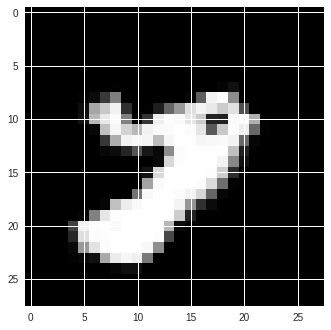

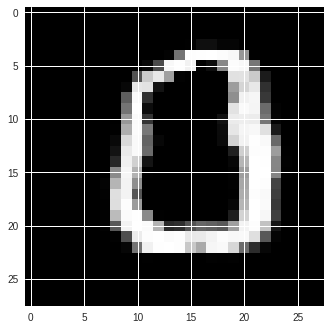

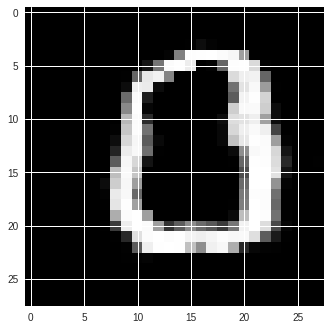

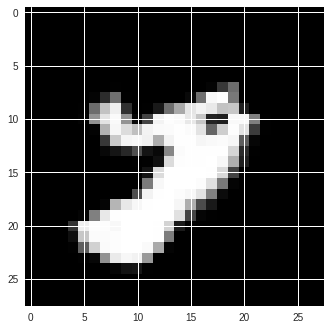

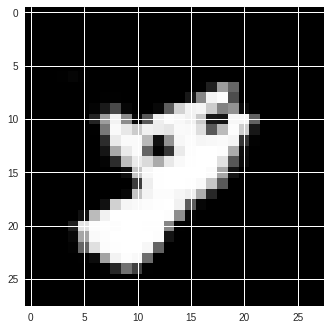

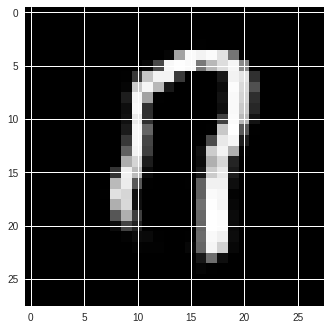

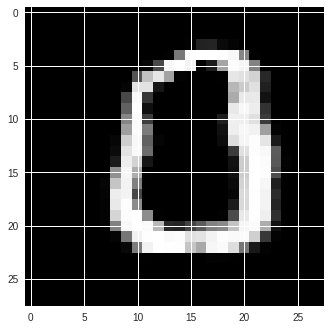

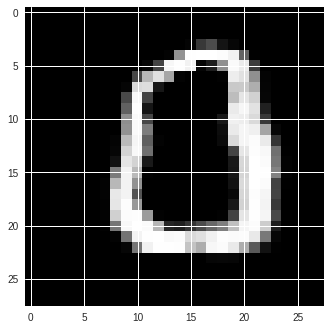

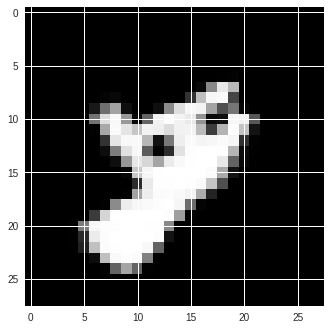

tensor(0.6724, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2020, device='cuda:0', grad_fn=<ThAddBackward>)
40th iteration gen_loss: 0.6724491119384766 dis_loss: 0.20195385813713074
tensor(0.4874, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3366, device='cuda:0', grad_fn=<ThAddBackward>)
40th iteration gen_loss: 0.4873930811882019 dis_loss: 0.336556613445282
tensor(0.5546, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3356, device='cuda:0', grad_fn=<ThAddBackward>)
40th iteration gen_loss: 0.554621160030365 dis_loss: 0.3356117904186249


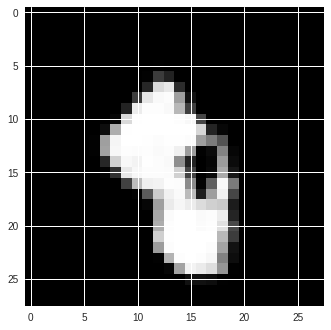

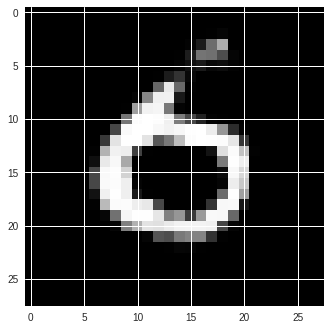

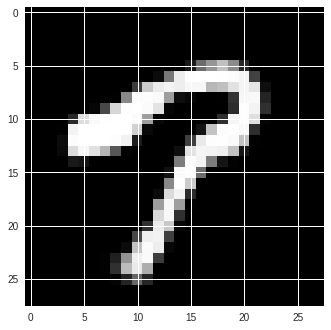

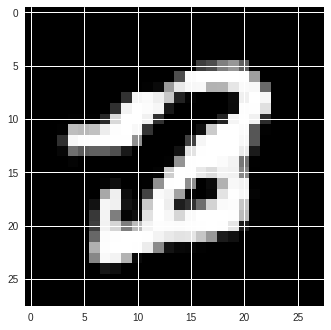

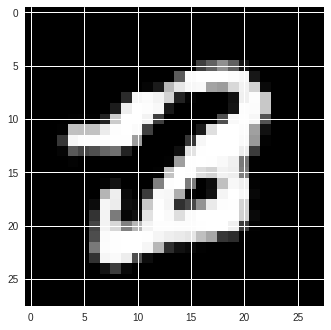

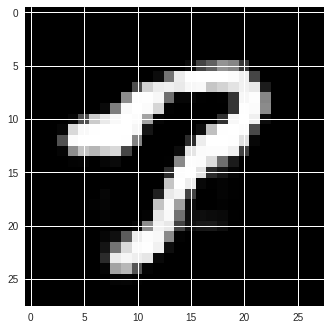

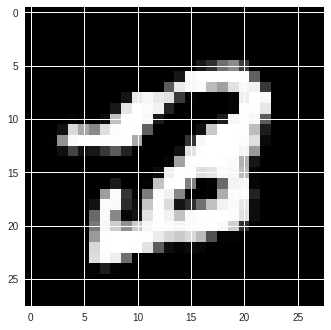

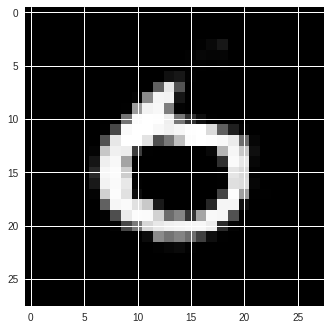

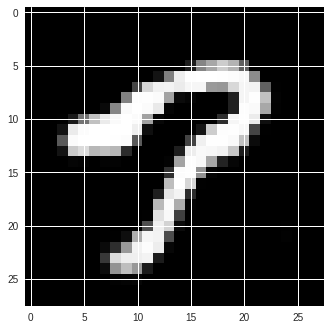

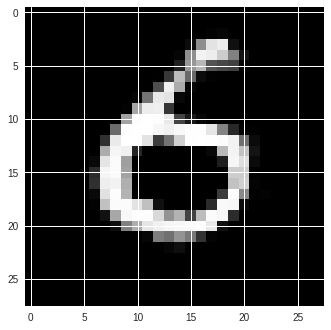

tensor(0.7314, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4507, device='cuda:0', grad_fn=<ThAddBackward>)
41th iteration gen_loss: 0.731392502784729 dis_loss: 0.450676828622818
tensor(0.5105, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2999, device='cuda:0', grad_fn=<ThAddBackward>)
41th iteration gen_loss: 0.5105102062225342 dis_loss: 0.29993054270744324
tensor(0.3919, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2820, device='cuda:0', grad_fn=<ThAddBackward>)
41th iteration gen_loss: 0.39192405343055725 dis_loss: 0.2820238769054413


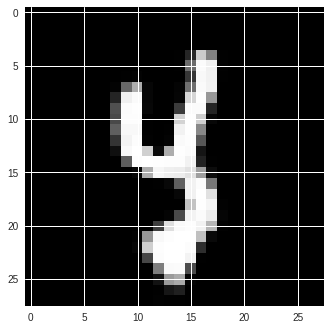

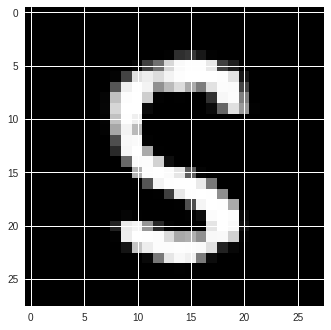

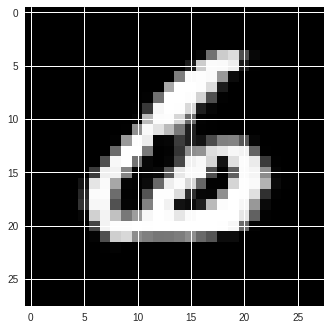

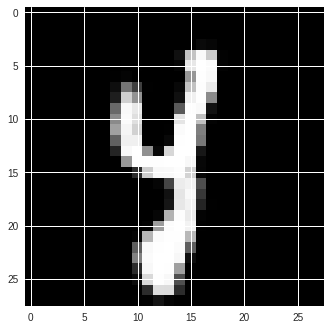

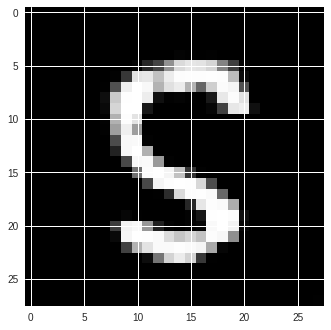

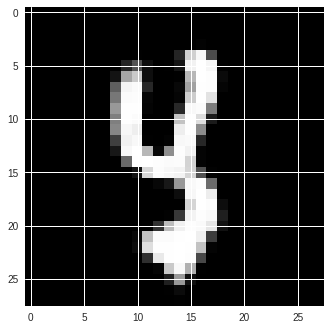

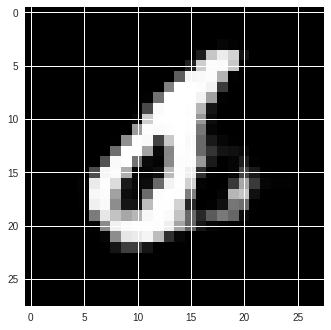

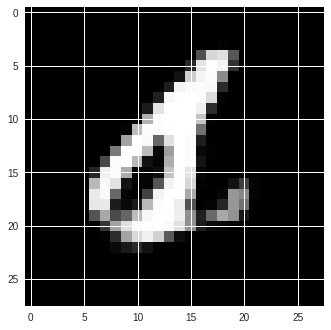

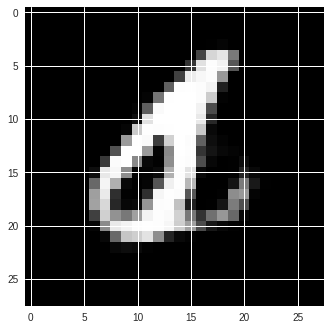

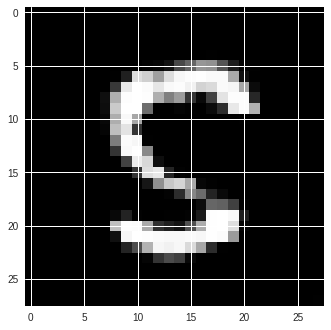

tensor(0.5956, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2295, device='cuda:0', grad_fn=<ThAddBackward>)
42th iteration gen_loss: 0.5956103801727295 dis_loss: 0.22945484519004822
tensor(0.5952, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2361, device='cuda:0', grad_fn=<ThAddBackward>)
42th iteration gen_loss: 0.595217764377594 dis_loss: 0.2360924631357193
tensor(0.6087, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2720, device='cuda:0', grad_fn=<ThAddBackward>)
42th iteration gen_loss: 0.6087035536766052 dis_loss: 0.2719990313053131


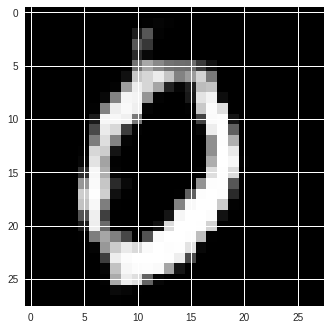

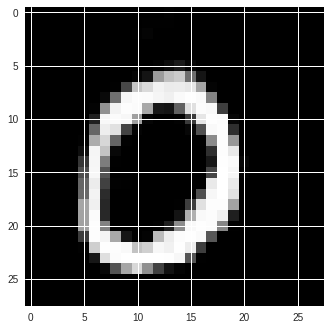

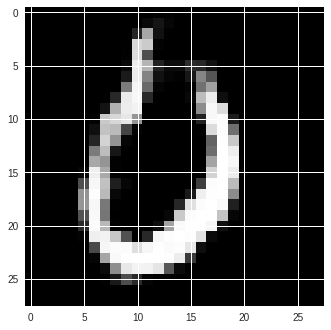

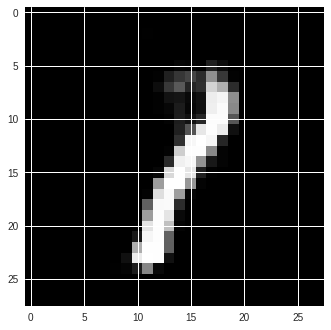

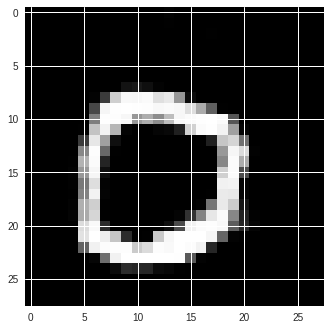

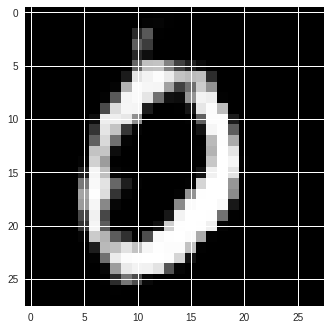

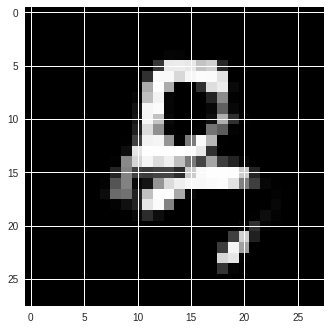

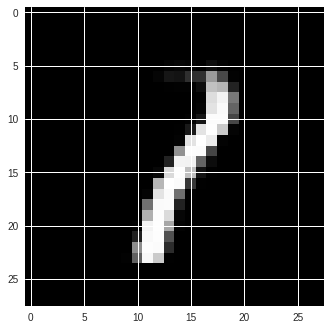

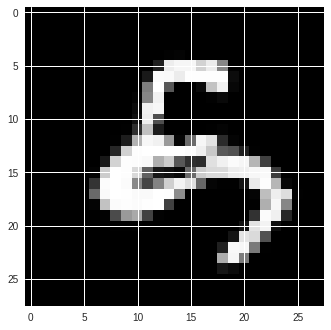

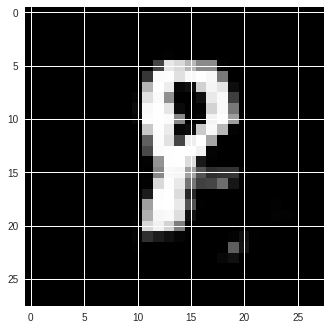

tensor(0.6088, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2882, device='cuda:0', grad_fn=<ThAddBackward>)
43th iteration gen_loss: 0.6088451743125916 dis_loss: 0.2881627678871155
tensor(0.4213, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3908, device='cuda:0', grad_fn=<ThAddBackward>)
43th iteration gen_loss: 0.4212970435619354 dis_loss: 0.3908132314682007
tensor(0.4801, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2759, device='cuda:0', grad_fn=<ThAddBackward>)
43th iteration gen_loss: 0.48009705543518066 dis_loss: 0.27588698267936707


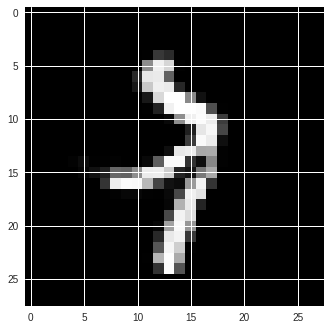

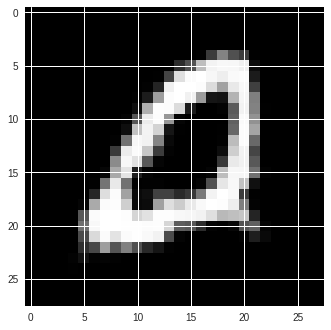

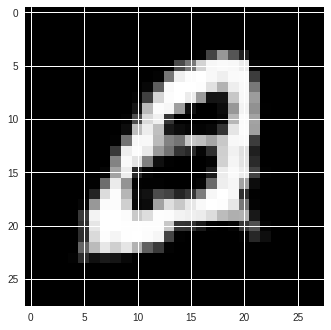

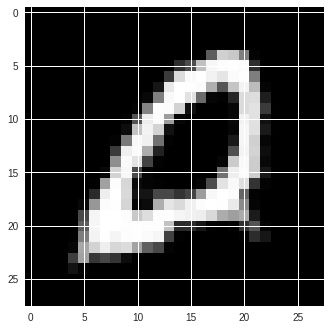

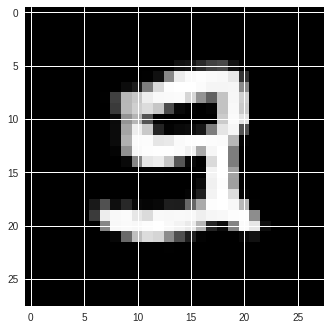

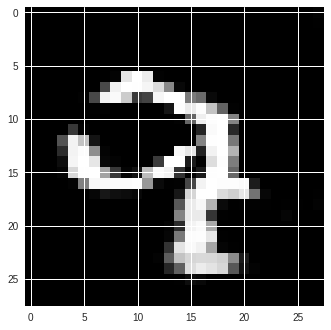

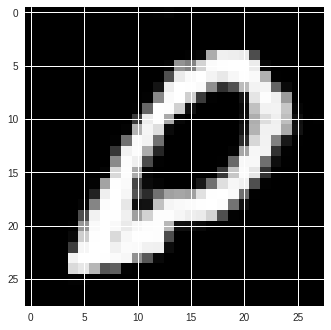

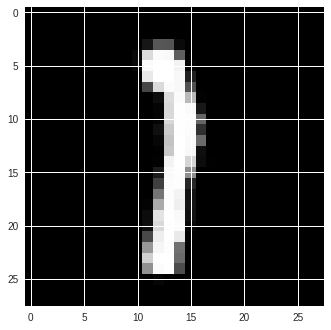

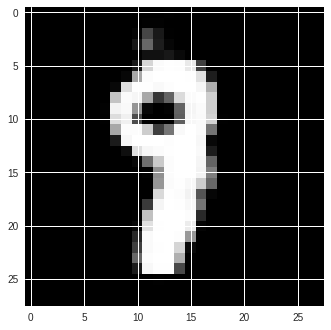

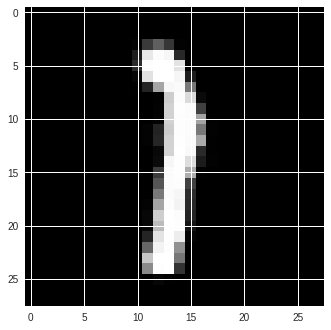

tensor(0.5707, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2061, device='cuda:0', grad_fn=<ThAddBackward>)
44th iteration gen_loss: 0.5707074403762817 dis_loss: 0.20609056949615479
tensor(0.4554, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3049, device='cuda:0', grad_fn=<ThAddBackward>)
44th iteration gen_loss: 0.45538055896759033 dis_loss: 0.3049495220184326
tensor(0.5977, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3259, device='cuda:0', grad_fn=<ThAddBackward>)
44th iteration gen_loss: 0.597671389579773 dis_loss: 0.3259483873844147


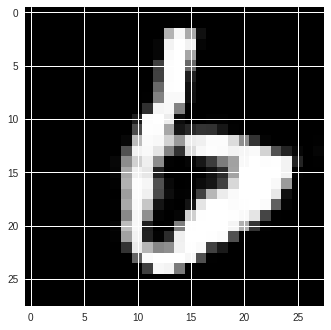

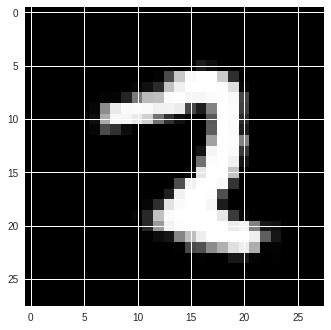

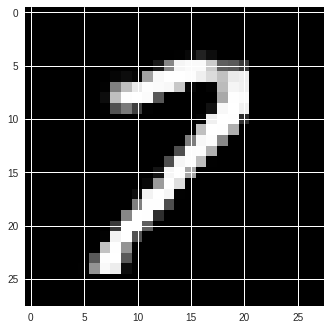

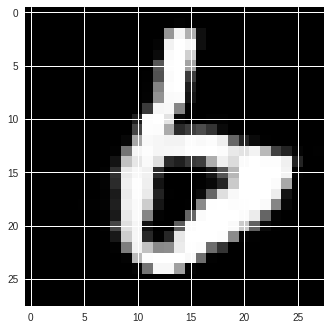

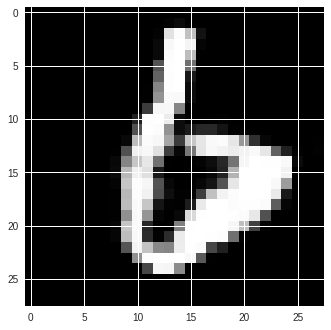

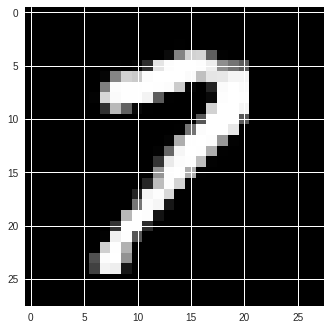

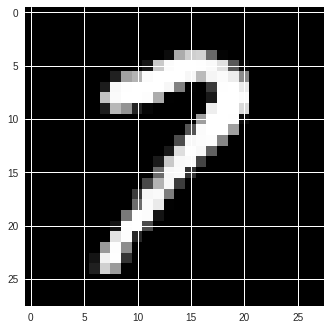

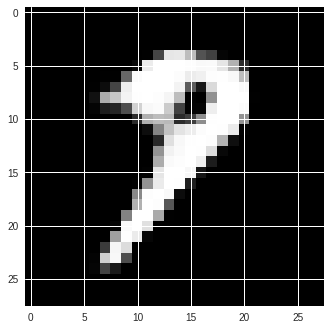

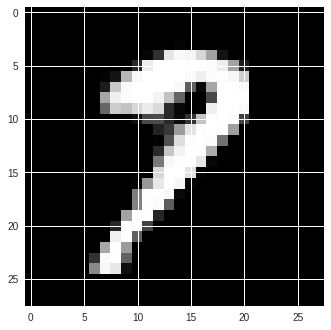

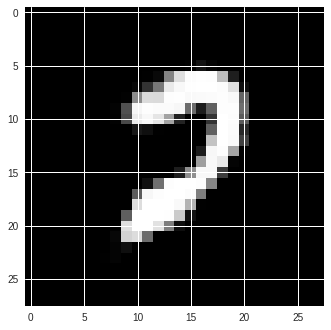

tensor(0.5495, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2699, device='cuda:0', grad_fn=<ThAddBackward>)
45th iteration gen_loss: 0.5494650602340698 dis_loss: 0.2698795199394226
tensor(0.6240, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2906, device='cuda:0', grad_fn=<ThAddBackward>)
45th iteration gen_loss: 0.6240214705467224 dis_loss: 0.2905508577823639
tensor(0.6070, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2232, device='cuda:0', grad_fn=<ThAddBackward>)
45th iteration gen_loss: 0.6070008277893066 dis_loss: 0.22322073578834534


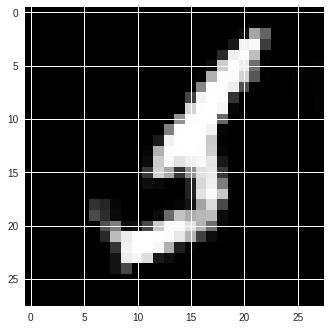

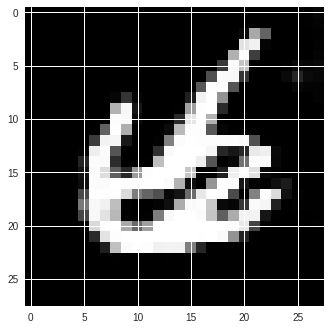

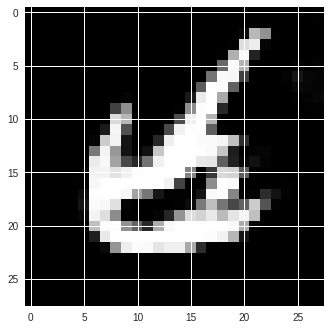

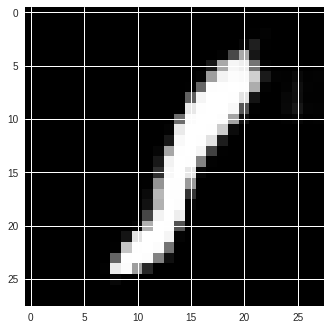

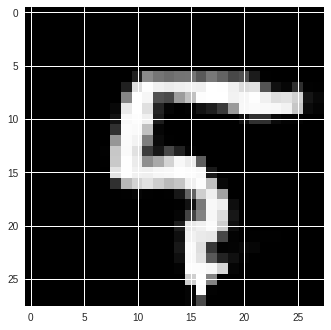

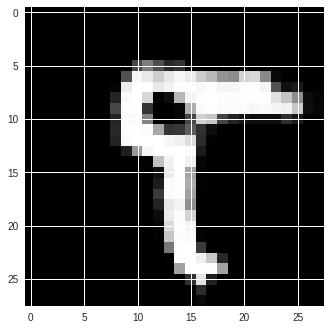

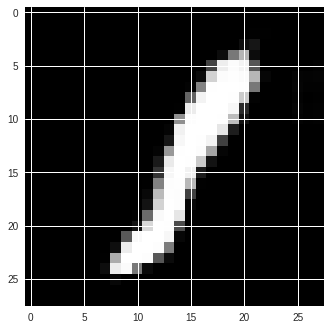

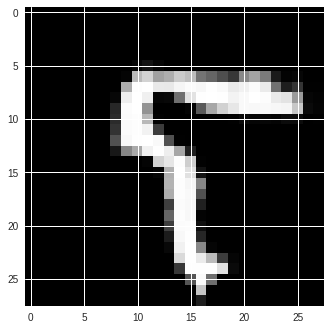

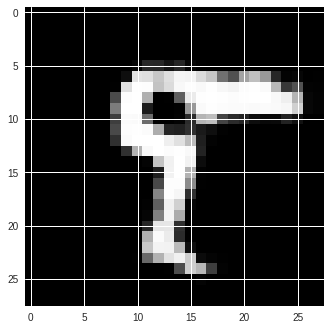

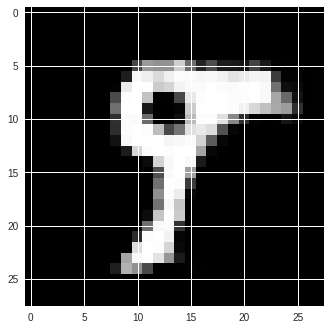

tensor(0.4083, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2090, device='cuda:0', grad_fn=<ThAddBackward>)
46th iteration gen_loss: 0.40825802087783813 dis_loss: 0.2090240716934204
tensor(0.6642, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1786, device='cuda:0', grad_fn=<ThAddBackward>)
46th iteration gen_loss: 0.6641642451286316 dis_loss: 0.1786249876022339
tensor(0.4644, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2739, device='cuda:0', grad_fn=<ThAddBackward>)
46th iteration gen_loss: 0.4644443094730377 dis_loss: 0.27394479513168335


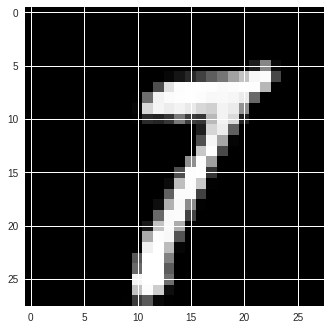

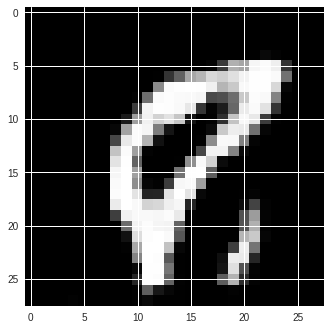

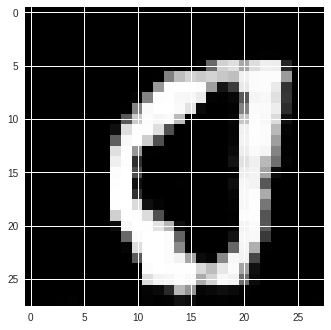

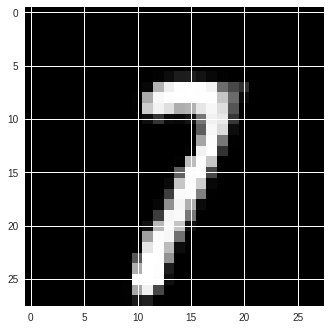

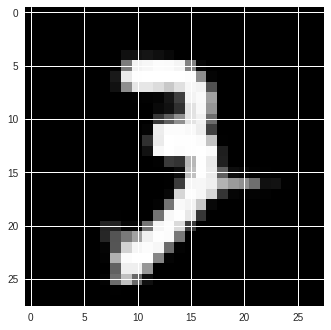

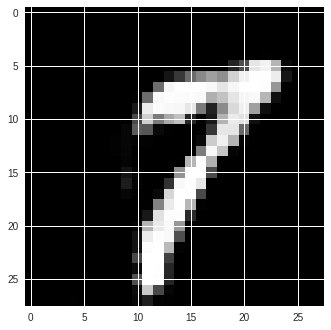

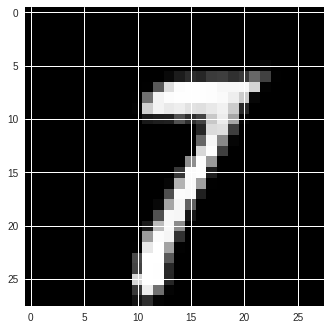

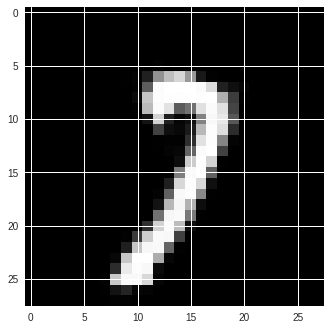

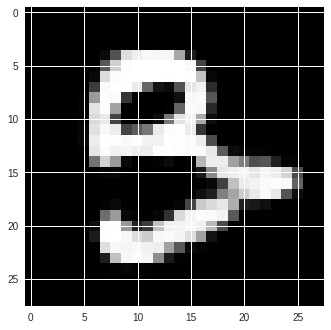

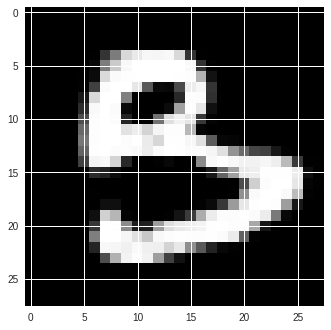

tensor(0.6037, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2455, device='cuda:0', grad_fn=<ThAddBackward>)
47th iteration gen_loss: 0.6037236452102661 dis_loss: 0.2455010712146759
tensor(0.7629, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3316, device='cuda:0', grad_fn=<ThAddBackward>)
47th iteration gen_loss: 0.76287442445755 dis_loss: 0.33164891600608826
tensor(0.5619, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2111, device='cuda:0', grad_fn=<ThAddBackward>)
47th iteration gen_loss: 0.5619024038314819 dis_loss: 0.21110031008720398


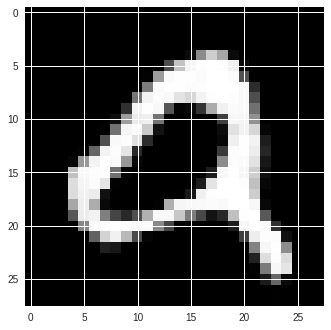

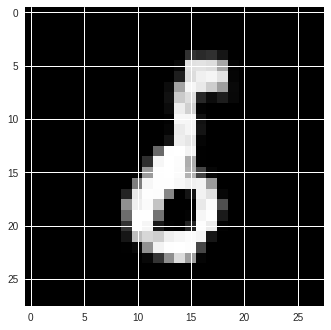

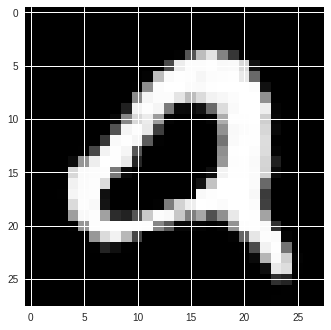

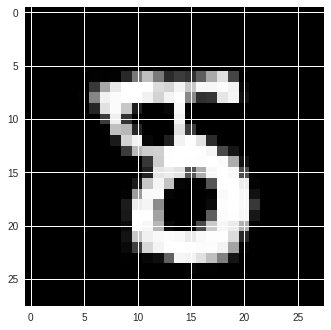

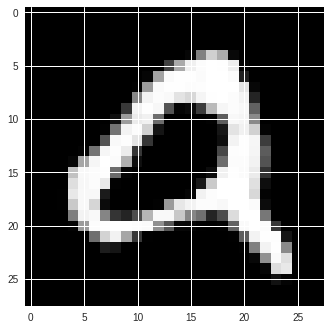

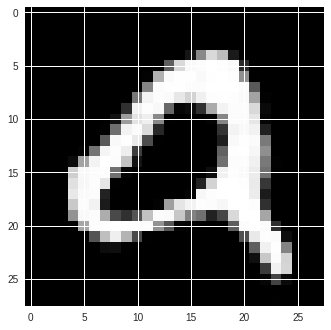

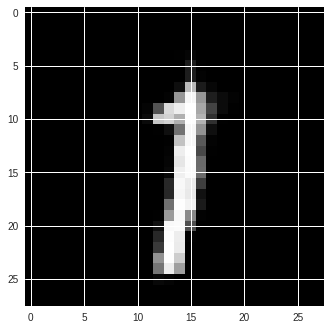

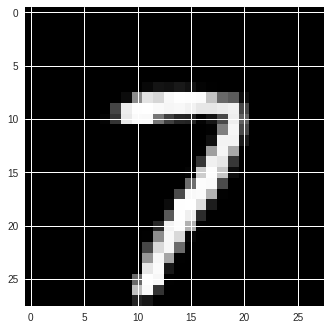

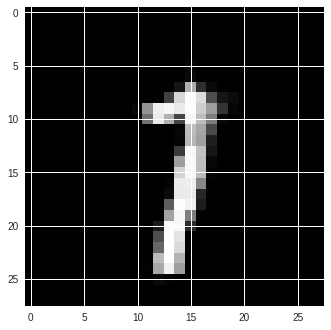

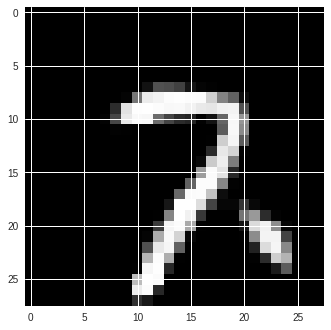

tensor(0.7325, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1594, device='cuda:0', grad_fn=<ThAddBackward>)
48th iteration gen_loss: 0.7324876189231873 dis_loss: 0.15941838920116425
tensor(0.6249, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.1803, device='cuda:0', grad_fn=<ThAddBackward>)
48th iteration gen_loss: 0.6248904466629028 dis_loss: 0.18032550811767578
tensor(0.6135, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2577, device='cuda:0', grad_fn=<ThAddBackward>)
48th iteration gen_loss: 0.6135154366493225 dis_loss: 0.2577492594718933


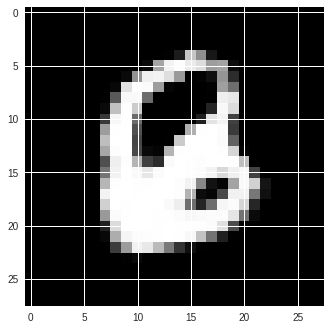

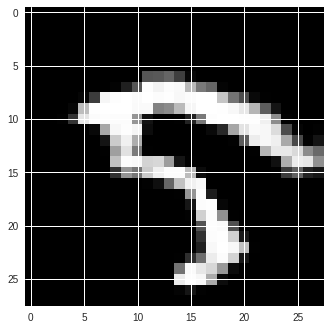

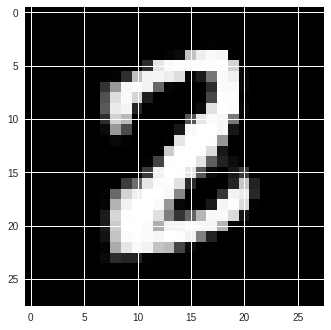

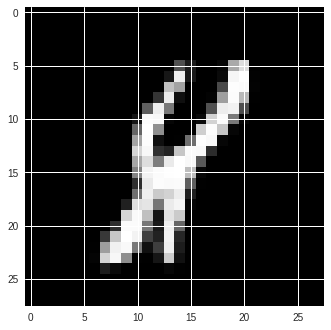

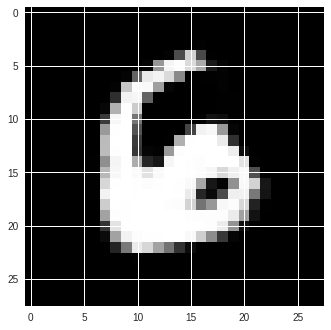

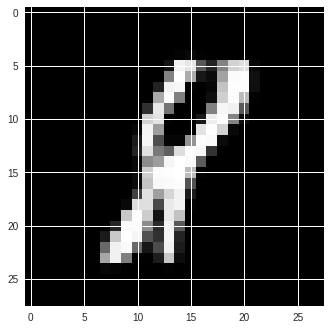

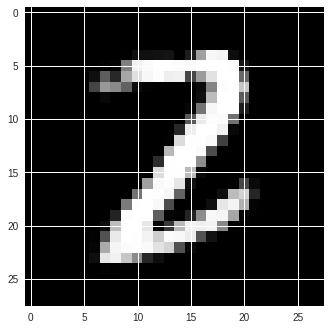

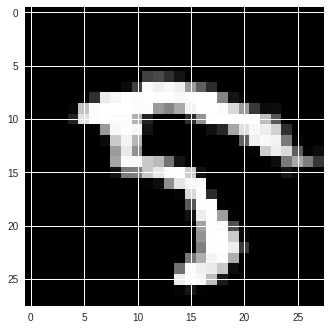

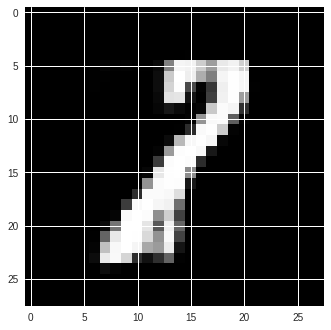

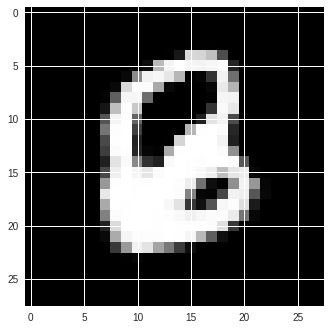

tensor(0.5099, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2553, device='cuda:0', grad_fn=<ThAddBackward>)
49th iteration gen_loss: 0.5098520517349243 dis_loss: 0.2553083598613739
tensor(0.7435, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3735, device='cuda:0', grad_fn=<ThAddBackward>)
49th iteration gen_loss: 0.7435102462768555 dis_loss: 0.37347912788391113
tensor(0.6206, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2452, device='cuda:0', grad_fn=<ThAddBackward>)
49th iteration gen_loss: 0.6205949783325195 dis_loss: 0.2452351152896881


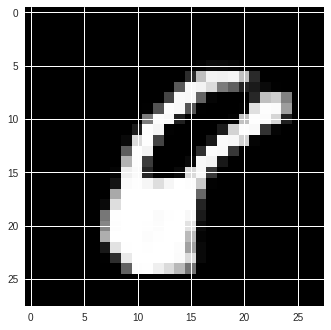

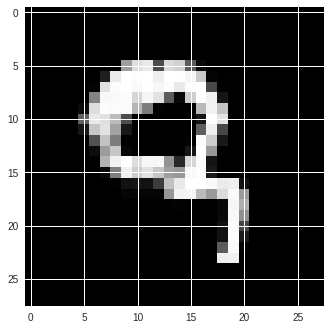

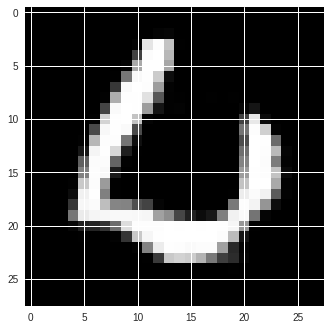

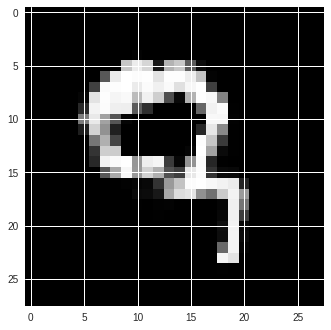

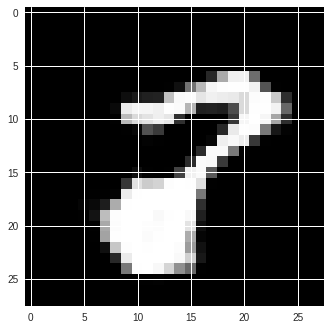

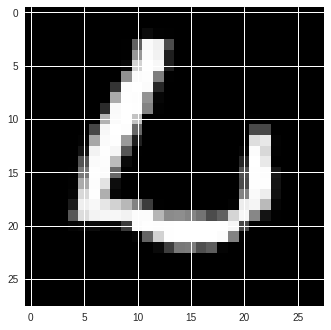

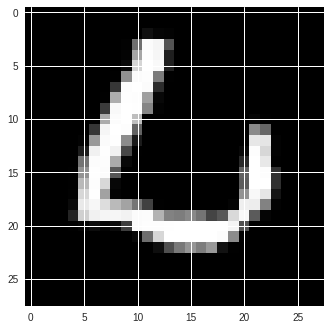

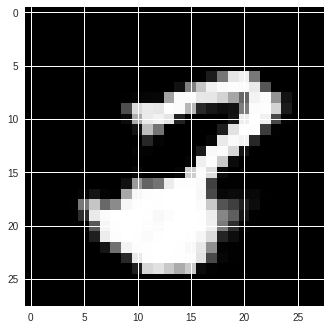

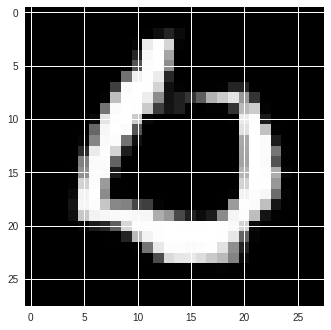

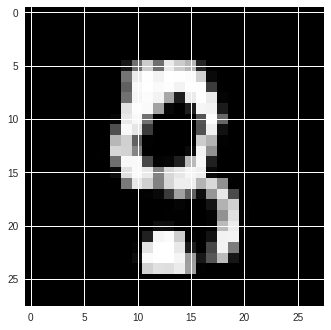

In [18]:
# train

for i in range(epoch):
    for j,(image,label) in enumerate(train_loader): #DataLoader에서 batch 만큼씩 가져온다.
        image = image.cuda()
        
        # generator
        gen_optim.zero_grad() #optimiser.step() 으로 업데이트된 그라디언트 값들을 초기화해 줘야 한다.
        
#         z = torch.normal(batch_size, 100).cuda()
        z = init.normal_(torch.Tensor(batch_size,100),mean=0,std=0.1).cuda() #noise 생성
        #매번 랜덤한 noise를 생성해서 이미지를 generate한다.
        #Autoencoder의 decoder에는 원래 latent vector가 있어야 하지만 GAN에서는 random noise에서 생성하는 것이 기본이다.
        gen_fake = generator.forward(z) #noise vector를 generator에 넣어주면, fake data가 생성된다.
        dis_fake = discriminator.forward(gen_fake) #fake data를 discriminator에 넣어준다.
        
        gen_loss = torch.sum(loss_func(dis_fake,ones_label)) #예측한 값과, 정답 # fake classified as real
        gen_loss.backward(retain_graph=True)
        gen_optim.step()
    
    
    
    
    
        # discriminator
        dis_optim.zero_grad() #optimiser.step() 으로 업데이트된 그라디언트 값들을 초기화해 줘야 한다.
        
#         z = Variable(init.normal(torch.Tensor(batch_size,100),mean=0,std=0.1)).cuda()
        z = init.normal_(torch.Tensor(batch_size,100),mean=0,std=0.1).cuda() #noise 생성
        gen_fake = generator.forward(z) #noise vector를 generator에 넣어주면, fake data가 생성된다.
        dis_fake = discriminator.forward(gen_fake) #fake data를 discriminator에 넣어준다.
        
        dis_real = discriminator.forward(image) #real data를 discriminator에 넣어준다.
        dis_loss = torch.sum(loss_func(dis_fake,zeros_label)) + torch.sum(loss_func(dis_real,ones_label))
        #Discriminator 입장에서는 생성된 fake data를 0로 판단하고, real data는 1로 판단해야 한다.
        #두 과정의 loss를 더해준다.
        dis_loss.backward() #역전파 해준다.
        dis_optim.step() #변수 업데이트
    
        # model save
        if j % 50 == 0:
            print(gen_loss,dis_loss)
#             torch.save([generator,discriminator],'./model/dcgan.pkl') #모델 저장

            print("{}th iteration gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))
#             v_utils.save_image(gen_fake.data[0:25],"./result/gen_{}_{}.png".format(i,j), nrow=5) #이미지 저장
            
    image_check(gen_fake.cpu())
    
#학습이 잘 되면, Discriminator의 결과값은 0.5에 수렴하게 된다. 이는 진짜 인지 아닌지 구별이 불가능한 상태를 의미한다.
#하지만, Discriminator가 제대로 학습이 안되서 구별을 못하는 경우에도 0.5에 수렴하게 나올 수 있다.
#아직은 따로 결과를 판단하는 metric이 없어 사람이 직접 눈으로 생성된 이미지를 보고 학습이 제대로 되었는지 판단해야 한다.  